## Importing Libraries

In [1]:
import requests
import string
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
plt.rcParams["figure.figsize"] = [10,6]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rcParams.update({'legend.fontsize': 11})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'font.size': 15})

## Extracting Data from API

In [3]:
# Run this to get data from latest list of 250 movies
# URL = "http://www.imdb.com/chart/top"
# r = requests.get(URL)
# soup = BeautifulSoup(r.content, "lxml")
# entries=soup.findAll('div', class_="wlb_ribbon")
# movie_ids=[]
# for a in entries:
#     movie_ids.append(a['data-tconst'])

In [4]:
# header = 'http://www.omdbapi.com/'
# api_key = 'you_api_key'
# movie_info=[]
# for i in movie_ids:
#     url=f"{header}?i={i}&apikey={api_key}"
#     r=requests.get(url).json()
#     movie=[]
#     for a in r.keys():
#         movie.append(r[a])
#     movie_info.append(movie)
# columns=r.keys()
# df=pd.DataFrame(movie_info, columns=columns)

In [5]:
# df.head()
# df.to_csv('top_250_imdb_movies.csv')

## Loading the Data From CSV

In [6]:
imdb = pd.read_csv('top_250_imdb_movies.csv')
imdb.head()

Unnamed: 0                     Title  Year     Rated     Released  Runtime  \
0           0  The Shawshank Redemption  1994         R  14 Oct 1994  142 min   
1           1             The Godfather  1972         R  24 Mar 1972  175 min   
2           2           The Dark Knight  2008     PG-13  18 Jul 2008  152 min   
3           3    The Godfather: Part II  1974         R  18 Dec 1974  202 min   
4           4              12 Angry Men  1957  Approved  10 Apr 1957   96 min   

                  Genre              Director  \
0                 Drama        Frank Darabont   
1          Crime, Drama  Francis Ford Coppola   
2  Action, Crime, Drama     Christopher Nolan   
3          Crime, Drama  Francis Ford Coppola   
4          Crime, Drama          Sidney Lumet   

                                              Writer  \
0                       Stephen King, Frank Darabont   
1                   Mario Puzo, Francis Ford Coppola   
2  Jonathan Nolan, Christopher Nolan, David S. Goyer   
3                   Francis Ford Coppola, Mario Puzo   
4                                      Reginald Rose   

                                        Actors  ... Metascore imdbRating  \
0      Tim Robbins, Morgan Freeman, Bob Gunton  ...      81.0        9.3   
1         Marlon Brando, Al Pacino, James Caan  ...     100.0        9.2   
2  Christian Bale, Heath Ledger, Aaron Eckhart  ...      84.0        9.1   
3     Al Pacino, Robert De Niro, Robert Duvall  ...      90.0        9.0   
4      Henry Fonda, Lee J. Cobb, Martin Balsam  ...      96.0        9.0   

   imdbVotes     imdbID   Type          DVD     BoxOffice  Production Website  \
0  2,559,562  tt0111161  movie  21 Dec 1999   $28,767,189         NaN     NaN   
1  1,765,414  tt0068646  movie  11 May 2004  $136,381,073         NaN     NaN   
2  2,528,462  tt0468569  movie  09 Dec 2008  $534,987,076         NaN     NaN   
3  1,222,153  tt0071562  movie  24 May 2005   $47,834,595         NaN     NaN   
4    756,234  tt0050083  movie  04 Mar 2008           NaN         NaN     NaN   

  Response  
0     True  
1     True  
2     True  
3     True  
4     True  

[5 rows x 26 columns]

## EDA: Analyzing Columns to Choose for Clustering

In [7]:
# Empty Dataframe to be used for CLustering
imdb_work = pd.DataFrame()


### Title: Identifier

In [8]:
# Title: Required to identify an entity in dataset.
imdb['Title']

0      The Shawshank Redemption
1                 The Godfather
2               The Dark Knight
3        The Godfather: Part II
4                  12 Angry Men
                 ...           
245        Beauty and the Beast
246                      Gandhi
247                    The Help
248              The Handmaiden
249                    Jai Bhim
Name: Title, Length: 250, dtype: object

In [9]:
# Checking Duplicate Titles : No Duplicates found
imdb['Title'].duplicated().sum()

0

### Year: Year of Release of Movie

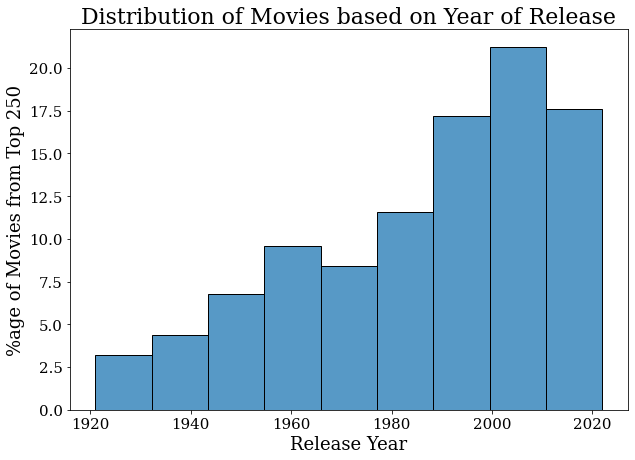

In [10]:
# Year: The year column helps in identifying the year in which a 
#        particular group of movies were released. 
#        Hence, can be used to form clusters
plt.figure(figsize=(10,7))
sns.histplot(imdb['Year'],stat='percent')
plt.xlabel('Release Year', fontsize=18)
plt.ylabel('%age of Movies from Top 250', fontsize=18)
plt.title('Distribution of Movies based on Year of Release', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Binning Year: Binarization

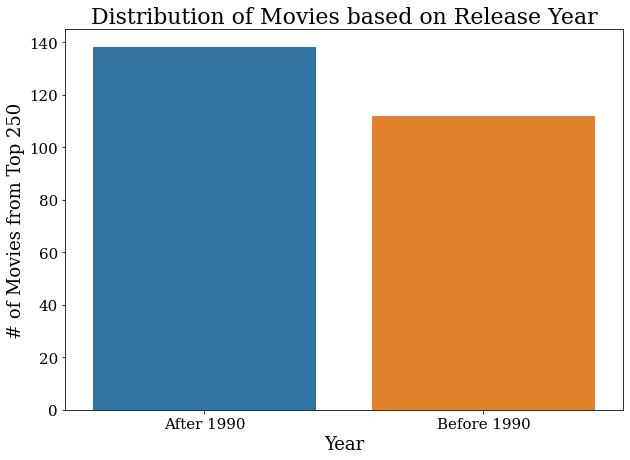

In [11]:
# Since 50% of data lies after year 1990, we convert year into binary variable
# with 0 as less than 1990 and 1 as more than 1990 to produce balanced data

imdb['Year_bin'] = imdb['Year'].apply(lambda x:0 if x<1990 else 1)
plt.figure(figsize=(10,7))
sns.countplot(x=imdb['Year_bin'].apply(lambda x:'Before 1990' if x==0 else 'After 1990'))
plt.xlabel('Year', fontsize=18)
plt.ylabel('# of Movies from Top 250', fontsize=18)
plt.title('Distribution of Movies based on Release Year', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Rated: Movie Rating as Per Rating System of Censorship

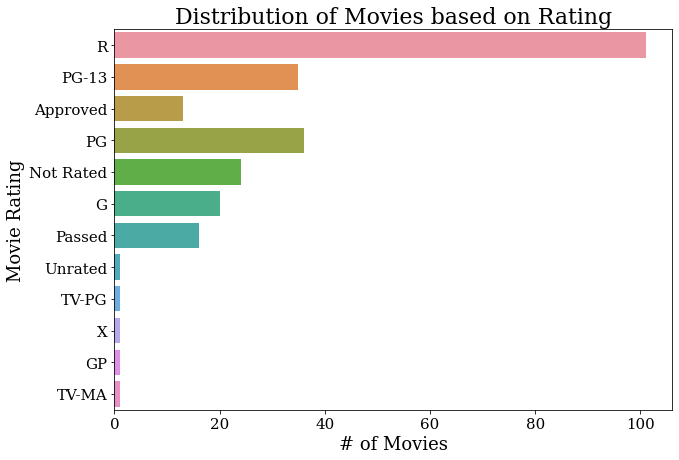

In [12]:
# Rated: The rating of movies is a good indication of categorizing them. 
#        It is very useful to form clusters
plt.figure(figsize=(10,7))
sns.countplot(y=imdb['Rated'])
plt.xlabel('# of Movies', fontsize=18)
plt.ylabel('Movie Rating', fontsize=18)
plt.title('Distribution of Movies based on Rating', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Mergining Rated Categories

Approved  G  Not Rated  PG  PG-13  Passed  R
0         0  0          0   0      0       0  1
1         0  0          0   0      0       0  1
2         0  0          0   0      1       0  0
3         0  0          0   0      0       0  1
4         1  0          0   0      0       0  0

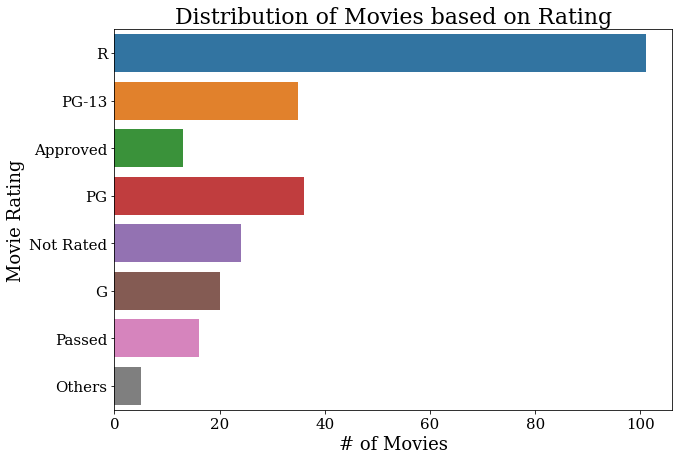

In [13]:
# Taking only significant ratings and combining others
imdb['Rated_Cat'] = imdb['Rated'].apply(lambda x: x if x not in ['Unrated', 'TV-PG', 'X', 'GP', 'TV-MA'] else 'Others')
rated_df = pd.get_dummies(imdb['Rated_Cat']).drop('Others',axis=1)
display(rated_df.head())
plt.figure(figsize=(10,7))
sns.countplot(y=imdb['Rated_Cat'])
plt.xlabel('# of Movies', fontsize=18)
plt.ylabel('Movie Rating', fontsize=18)
plt.title('Distribution of Movies based on Rating', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Runtime: Length of Movie in Mins

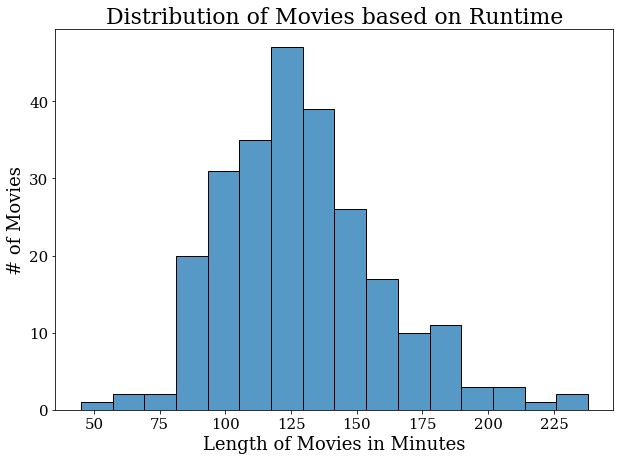

In [14]:
# Runtime: It defines the total length of the movie. 
#          A good factor to consider while forming clusters
plt.figure(figsize=(10,7))
sns.histplot(imdb['Runtime'].apply(lambda x:float(x.split()[0])))
plt.xlabel('Length of Movies in Minutes', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('Distribution of Movies based on Runtime', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Binning Runtime: Short, Normal, Long

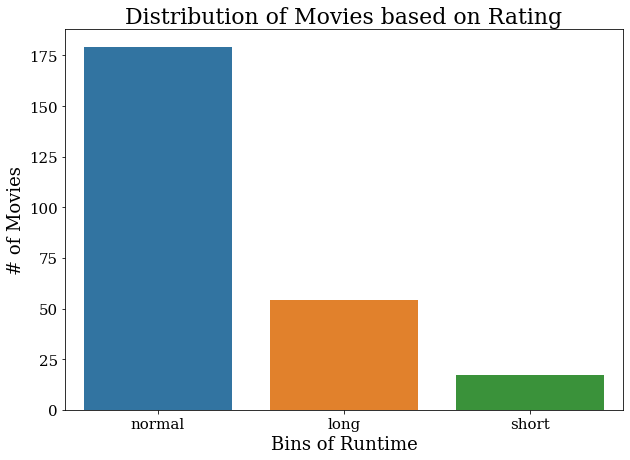

In [15]:
# Function to form Bins
def bin_runtime(Runtime):
  Runtime = float(Runtime.split()[0])
  if Runtime <90:
    return 'short'
  elif Runtime<150:
    return 'normal'
  else:
    return 'long'

# Binning Runtime for eliminating a dominating Numerical Variable in Dataset
# As it can dominate the clustering effect.
imdb['Runtime_bin'] = imdb['Runtime'].apply(bin_runtime)
Runtime_df = pd.get_dummies(imdb['Runtime_bin']).drop('short', axis = 1)
plt.figure(figsize=(10,7))
sns.countplot(x=imdb['Runtime_bin'])
plt.xlabel('Bins of Runtime', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('Distribution of Movies based on Rating', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Directors: Movie Directors

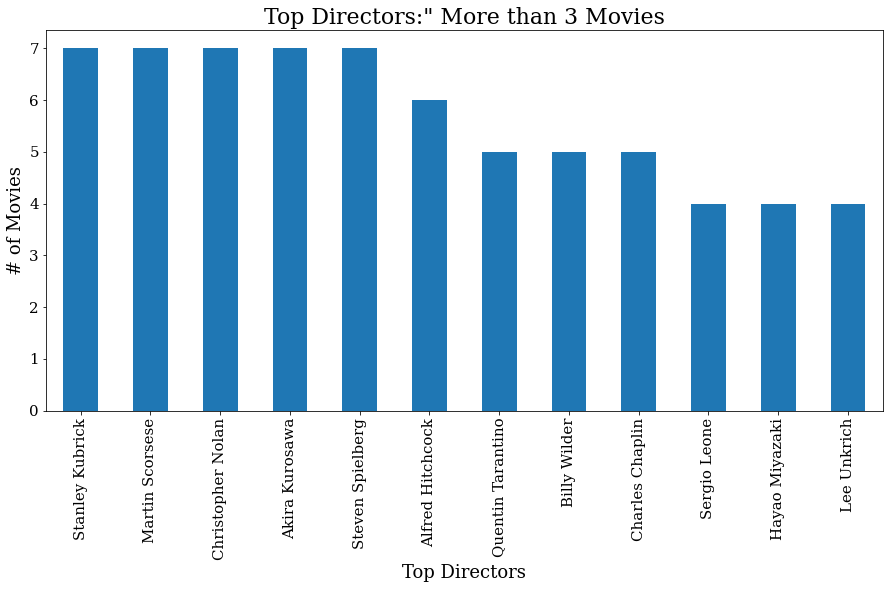

In [16]:
# Director: Directors of Movies 

plt.figure(figsize = (15,7))
mlb = MultiLabelBinarizer()
one_hot_encoded_director = mlb.fit_transform(imdb['Director'].apply(lambda x:set(x.split(', '))))
dir_df = pd.DataFrame(one_hot_encoded_director, columns=mlb.classes_)
plot_top_dirs = dir_df.sum().sort_values(ascending=False)

#select directors with atleast 3 movies
plot_top_dirs[plot_top_dirs>=4].plot.bar() # There are 24 such directors
plt.xlabel('Top Directors', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('Top Directors:" More than 3 Movies', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
top_dirs_list = list(plot_top_dirs[plot_top_dirs>=4].index)

# drop columns with other directors # Base class- other directors
for col in dir_df.columns: 
  if col not in top_dirs_list:
    dir_df.drop(columns=col, inplace = True)

### Writer: Movie Writers

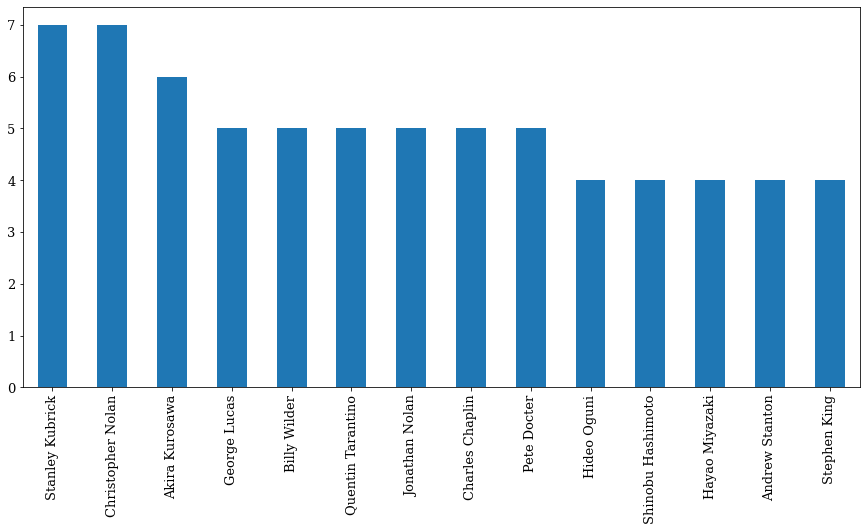

In [17]:
# Writer: Writer of Movies

plt.figure(figsize = (15,7))
mlb = MultiLabelBinarizer()
one_hot_encoded_writer = mlb.fit_transform(imdb['Writer'].apply(lambda x:set(x.split(', '))))
writer_df = pd.DataFrame(one_hot_encoded_writer, columns=mlb.classes_)
plot_top_writer = writer_df.sum().sort_values(ascending=False)

#select writers with atleast 4 movies
plot_top_writer[plot_top_writer>=4].plot.bar() # There are 14 such writers
top_writer_list = list(plot_top_writer[plot_top_writer>=4].index)

# drop columns with other writers # Base class- other writers
for col in writer_df.columns: 
  if col not in top_writer_list:
    writer_df.drop(columns=col, inplace = True)

### Actors: Star of Movies

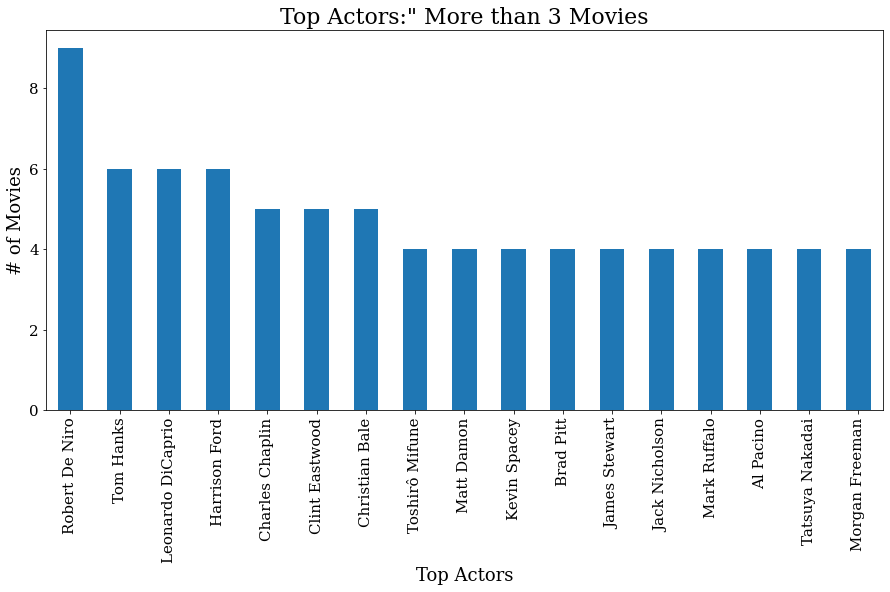

In [18]:
# Actors : Actors of Movies

plt.figure(figsize = (15,7))
mlb = MultiLabelBinarizer()
one_hot_encoded_actor = mlb.fit_transform(imdb['Actors'].apply(lambda x:set(x.split(', '))))
actors_df = pd.DataFrame(one_hot_encoded_actor, columns=mlb.classes_)
plot_top_actor = actors_df.sum().sort_values(ascending=False)

#select actors with atleast 4 movies
plot_top_actor[plot_top_actor>=4].plot.bar() # There are 14 such actors
plt.xlabel('Top Actors', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('Top Actors:" More than 3 Movies', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
top_actor_list = list(plot_top_actor[plot_top_actor>=4].index)

# drop columns with other actors # Base class- other actors
for col in actors_df.columns: 
  if col not in top_actor_list:
    actors_df.drop(columns=col, inplace = True)

### Language: Languages in which Released

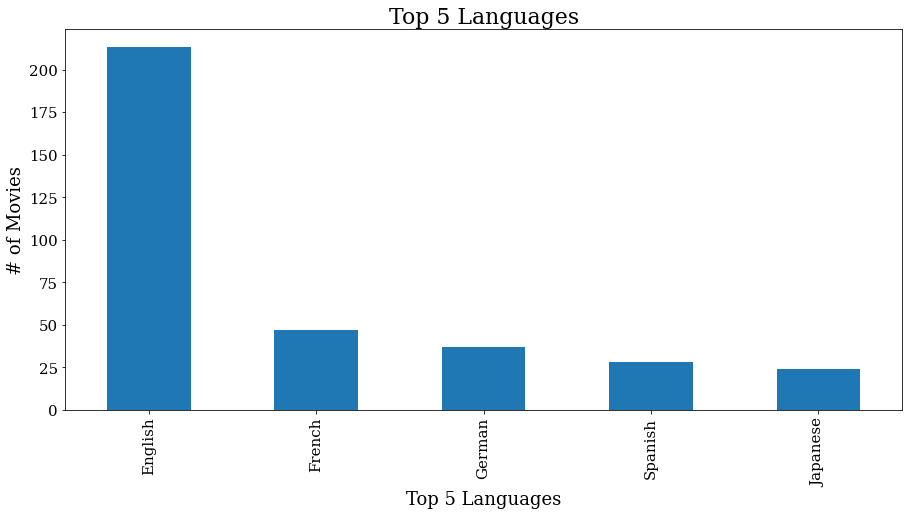

In [19]:
# Language :  Language of Movies

plt.figure(figsize = (15,7))
mlb = MultiLabelBinarizer()
one_hot_encoded_language = mlb.fit_transform(imdb['Language'].apply(lambda x:set(x.split(', '))))
lang_df = pd.DataFrame(one_hot_encoded_language, columns=mlb.classes_)
plot_top_language = lang_df.sum().sort_values(ascending=False)

#select top 10  languages
plot_top_language[0:5].plot.bar() 
plt.xlabel('Top 5 Languages', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('Top 5 Languages', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
top_language_list = list(plot_top_language[0:5].index)

# drop columns with other languages # Base class- other language
for col in lang_df.columns: 
  if col not in top_language_list:
    lang_df.drop(columns=col, inplace = True)

### Genre: Genre of Movies

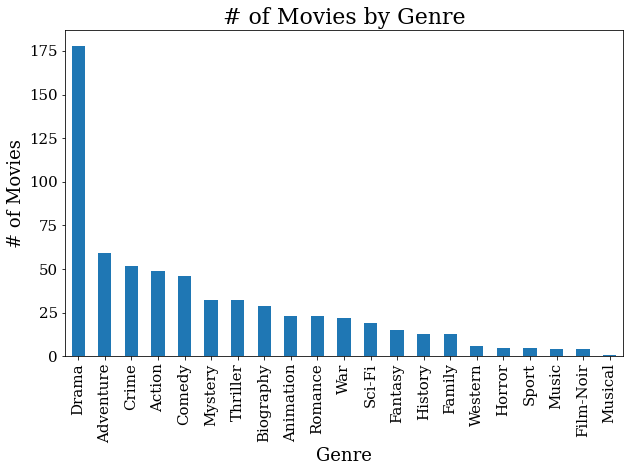

In [20]:
# Genre: It is an important factor to categorize movies

mlb = MultiLabelBinarizer()
one_hot_encoded_genre = mlb.fit_transform(imdb['Genre'].apply(lambda x:set(x.split(', '))))
genre_df = pd.DataFrame(one_hot_encoded_genre, columns=mlb.classes_)
genre_df.sum().sort_values(ascending=False).plot.bar()
plt.xlabel('Genre', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('# of Movies by Genre', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Country: Countries in which Movies are Released

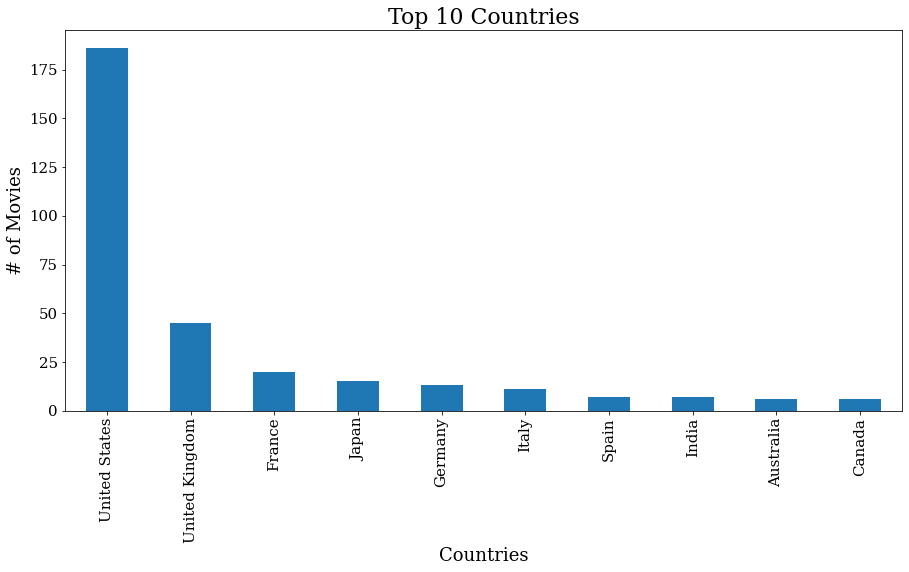

In [21]:
# Country : Country in which produced
plt.figure(figsize = (15,7))
mlb = MultiLabelBinarizer()
one_hot_encoded_country = mlb.fit_transform(imdb['Country'].apply(lambda x:set(x.split(', '))))
country_df = pd.DataFrame(one_hot_encoded_country, columns=mlb.classes_)
plot_top_country = country_df.sum().sort_values(ascending=False)

#select top 10  countries
plot_top_country[0:10].plot.bar() 
plt.xlabel('Countries', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.title('Top 10 Countries', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
top_country_list = list(plot_top_country[0:10].index)

# drop columns with other languages # Base class- other language
for col in country_df.columns: 
  if col not in top_country_list:
    country_df.drop(columns=col, inplace = True)

### Plot: Short summary of Movie Plot

In [22]:
# Plot: Plot of Film
nlp = spacy.load('en_core_web_sm')
stopwords = list(STOP_WORDS)


# This function tokenizes, lemmetizes each word and then removes stop words & punctuations
def preprocess(plot):
    vocab = nlp(plot)
    
    tokens = []
    for token in vocab:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in string.punctuation:
            cleaned_tokens.append(token)
    return cleaned_tokens

# Tf-Idf Vectorization of Plot Summaries
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess, ngram_range=(1,3))
tfidf_plot = tfidf_vectorizer.fit_transform(imdb['Plot'])

# Getting TFIDF Score for all Words extracted from all Plot Summaries
terms = tfidf_vectorizer.get_feature_names_out()
term_idf_sums = tfidf_plot.sum(axis=0)
term_idf_scores = []
for i in range(len(terms)):
    term_idf_scores.append([terms[i], term_idf_sums[0,i]])
term_idf_scores.sort(key=lambda x: x[1], reverse=True)

# Selecting Top 50 words based on TFIDF scores
print("\nTerms with Highest TF-IDF Scores: Top 50\n")
top_50_words = [word_weight[0] for word_weight in term_idf_scores[:25]]

# Creating Dataframe of top 50 words with their corresponding TFIDF scores
plot_df = pd.DataFrame(tfidf_plot.todense(), columns=terms)[top_50_words]
term_idf_scores[:25]


Terms with Highest TF-IDF Scores: Top 50



[['life', 3.0599922028696596],
 ['find', 2.753964181192047],
 ['young', 2.743182476435236],
 ['man', 2.5700444458252476],
 ['help', 2.2431113990726965],
 ['war', 2.164347140259702],
 ['old', 2.0481788383248714],
 ['world', 1.9316817387794125],
 ['new', 1.8785459794218486],
 ['year', 1.8320269924531813],
 ['friend', 1.775381881415749],
 ['try', 1.7696456944518761],
 ['family', 1.7514813588264666],
 ['murder', 1.7082474711820008],
 ['son', 1.657474339938519],
 ['woman', 1.6431298003310253],
 ['city', 1.6180586066359621],
 ['child', 1.5616801581971302],
 ['work', 1.5515159827185176],
 ['american', 1.47698813710787],
 ['struggle', 1.4003746352955133],
 ['boy', 1.3676396650189453],
 ['force', 1.3598680979100484],
 ['wife', 1.325188815561101],
 ['live', 1.2695896056126408]]

In [23]:
list(map(lambda x: x[1],term_idf_scores))[:25]

[3.0599922028696596,
 2.753964181192047,
 2.743182476435236,
 2.5700444458252476,
 2.2431113990726965,
 2.164347140259702,
 2.0481788383248714,
 1.9316817387794125,
 1.8785459794218486,
 1.8320269924531813,
 1.775381881415749,
 1.7696456944518761,
 1.7514813588264666,
 1.7082474711820008,
 1.657474339938519,
 1.6431298003310253,
 1.6180586066359621,
 1.5616801581971302,
 1.5515159827185176,
 1.47698813710787,
 1.4003746352955133,
 1.3676396650189453,
 1.3598680979100484,
 1.325188815561101,
 1.2695896056126408]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['calibri light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri light'] not found. Falling back to DejaVu Sans.


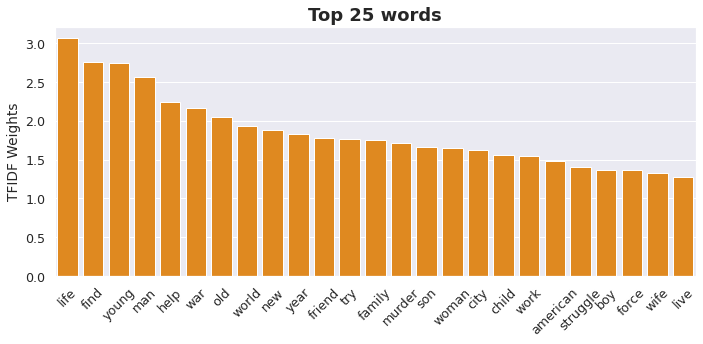

In [24]:
x = list(map(lambda x: x[0],term_idf_scores))[:25]
y = list(map(lambda x: x[1],term_idf_scores))[:25]

plt.figure(figsize=(10,5))
sns.set(font_scale = 1.15)
plt.rc('font', family='calibri light')
sns.barplot(x,y,color='#ff8c00')
plt.title("Top 25 words",fontsize=18, weight='bold')
plt.xticks(rotation=45)
plt.ylabel('TFIDF Weights')
#plt.barh(x,y)
plt.tight_layout()
sns.set_style('white')

### Final Dataset after Preprocessing

In [25]:
# Create Final DataFrame
imdb_work = pd.DataFrame()

#imdb_work['Runtime'] = imdb['Runtime'].apply(lambda x:float(x.split()[0])) # remove 'minutes'
imdb_work['Year'] = imdb['Year_bin']
imdb_work = pd.concat([imdb_work,
                       Runtime_df,
                       country_df,
                       genre_df,
                       actors_df,
                       dir_df,
                       plot_df,
                       rated_df], axis = 1)
imdb_work.set_index(imdb['Title'], inplace = True)

display(imdb_work.info(), imdb_work.head())

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, The Shawshank Redemption to Jai Bhim
Data columns (total 95 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               250 non-null    int64  
 1   long               250 non-null    uint8  
 2   normal             250 non-null    uint8  
 3   Australia          250 non-null    int64  
 4   Canada             250 non-null    int64  
 5   France             250 non-null    int64  
 6   Germany            250 non-null    int64  
 7   India              250 non-null    int64  
 8   Italy              250 non-null    int64  
 9   Japan              250 non-null    int64  
 10  Spain              250 non-null    int64  
 11  United Kingdom     250 non-null    int64  
 12  United States      250 non-null    int64  
 13  Action             250 non-null    int64  
 14  Adventure          250 non-null    int64  
 15  Animation          250 non-null    int64  
 16  Bio

None

Year  long  normal  Australia  Canada  France  \
Title                                                                     
The Shawshank Redemption     1     0       1          0       0       0   
The Godfather                0     1       0          0       0       0   
The Dark Knight              1     1       0          0       0       0   
The Godfather: Part II       0     1       0          0       0       0   
12 Angry Men                 0     0       1          0       0       0   

                          Germany  India  Italy  Japan  ...     force  wife  \
Title                                                   ...                   
The Shawshank Redemption        0      0      0      0  ...  0.000000   0.0   
The Godfather                   0      0      0      0  ...  0.000000   0.0   
The Dark Knight                 0      0      0      0  ...  0.000000   0.0   
The Godfather: Part II          0      0      0      0  ...  0.000000   0.0   
12 Angry Men                    0      0      0      0  ...  0.099648   0.0   

                          live  Approved  G  Not Rated  PG  PG-13  Passed  R  
Title                                                                         
The Shawshank Redemption   0.0         0  0          0   0      0       0  1  
The Godfather              0.0         0  0          0   0      0       0  1  
The Dark Knight            0.0         0  0          0   0      1       0  0  
The Godfather: Part II     0.0         0  0          0   0      0       0  1  
12 Angry Men               0.0         1  0          0   0      0       0  0  

[5 rows x 95 columns]

### Reasons of not considering other columns

In [26]:
# Why did not consider other columns
# 1. Released : The year is enough for that. We do not need the exact date
# 2. Awards: Since these are top movies from IMDB, they must have gotten awards so it is not a good measure for distinction
# 3. Poster: Its a link to imgaes which is not relevant for analysis
# 4. imdbvotes, Ratings, Metascore, Imdb Ratings: Since all have good ratings being the top 250, so not a good measure of distinction
# 5. imdb_id : Identifier field
# 6. type: all are movies
# 7. DVD: When was DVD Released
# 8. Production: Nan values
# 9. Website: Nan Values
# 10. Response: All True
# 11. Box Office : Not Considered

## PCA: Eliminating Curse of Dimensionality

In [27]:
pca = PCA().fit(imdb_work)

for i in range(10,30):
  #print(i)
  var = round(pca.explained_variance_ratio_[:i].sum(), 2)
  print(i,var)
  if var >= 0.8:
    print("\nThe optimum number of PCs is:",i)
    break

10 0.59
11 0.62
12 0.64
13 0.66
14 0.68
15 0.7
16 0.72
17 0.73
18 0.75
19 0.76
20 0.78
21 0.79
22 0.8

The optimum number of PCs is: 22


### Determining Top N componenets with sufficinet variance

In [28]:
# sc = StandardScaler()
# imdb_work_scaled = sc.fit_transform(imdb_work)
pca = PCA().fit(imdb_work)
top_PCA=["%.2f" % a for a in pca.explained_variance_ratio_ if a >=0.01]
print('Number of Top Pricipal Components : ',len(top_PCA))
print('Explained variance by Top PC : ', round(pca.explained_variance_ratio_[:21].sum(), 2)*100, '%')

Number of Top Pricipal Components :  25
Explained variance by Top PC :  79.0 %


In [29]:
imdb_work.head()

Year  long  normal  Australia  Canada  France  \
Title                                                                     
The Shawshank Redemption     1     0       1          0       0       0   
The Godfather                0     1       0          0       0       0   
The Dark Knight              1     1       0          0       0       0   
The Godfather: Part II       0     1       0          0       0       0   
12 Angry Men                 0     0       1          0       0       0   

                          Germany  India  Italy  Japan  ...     force  wife  \
Title                                                   ...                   
The Shawshank Redemption        0      0      0      0  ...  0.000000   0.0   
The Godfather                   0      0      0      0  ...  0.000000   0.0   
The Dark Knight                 0      0      0      0  ...  0.000000   0.0   
The Godfather: Part II          0      0      0      0  ...  0.000000   0.0   
12 Angry Men                    0      0      0      0  ...  0.099648   0.0   

                          live  Approved  G  Not Rated  PG  PG-13  Passed  R  
Title                                                                         
The Shawshank Redemption   0.0         0  0          0   0      0       0  1  
The Godfather              0.0         0  0          0   0      0       0  1  
The Dark Knight            0.0         0  0          0   0      1       0  0  
The Godfather: Part II     0.0         0  0          0   0      0       0  1  
12 Angry Men               0.0         1  0          0   0      0       0  0  

[5 rows x 95 columns]

In [30]:
imdb_work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, The Shawshank Redemption to Jai Bhim
Data columns (total 95 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               250 non-null    int64  
 1   long               250 non-null    uint8  
 2   normal             250 non-null    uint8  
 3   Australia          250 non-null    int64  
 4   Canada             250 non-null    int64  
 5   France             250 non-null    int64  
 6   Germany            250 non-null    int64  
 7   India              250 non-null    int64  
 8   Italy              250 non-null    int64  
 9   Japan              250 non-null    int64  
 10  Spain              250 non-null    int64  
 11  United Kingdom     250 non-null    int64  
 12  United States      250 non-null    int64  
 13  Action             250 non-null    int64  
 14  Adventure          250 non-null    int64  
 15  Animation          250 non-null    int64  
 16  Bio

In [31]:
import plotly.express as px

imdb_work.iloc[0:,:-1]

pca = PCA(n_components=2)
components = pca.fit_transform(imdb_work.iloc[0:,:-1])
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter(
    components, x=0, y=1, color=imdb['Runtime_bin'],
    title=f'Total Explained Variance: {total_var:.2f}%'+'\n\n\n\n'+'Runtime_bin_bin',
    labels={'0': 'PC 1 (11%)', '1': 'PC 2 (9%)', '2': 'PC 3 (8.5%)'})

fig.show()

In [32]:
pca = PCA(n_components=3)

imdb_work.iloc[0:,:-1]

components = pca.fit_transform(imdb_work.iloc[0:,:-1])
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=imdb['Runtime_bin'],
    title=f'Total Explained Variance: {total_var:.2f}%'+'\n\n\n\n'+'Runtime_bin',
    labels={'0': 'PC 1 (11%)', '1': 'PC 2 (9%)', '2': 'PC 3 (8.5%)'}
)
fig.show()

In [33]:
pca = PCA(n_components=4)
components = pca.fit_transform(imdb_work.iloc[0:,:-1])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=imdb['Runtime_bin'],
    title="Movie Length Devision by Principal Componensts"
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import plotly.express as px

imdb_work.iloc[0:,:-1]

pca = PCA(n_components=2)
components = pca.fit_transform(imdb_work.iloc[0:,:-4])

fig = px.scatter(components, x=0, y=1, color=imdb['Year_bin'],
    title= f'Total Explained Variance: {total_var:.2f}% '+' \n\n\n\n'+'Year_bin',
    labels={'0': 'PC 1 (11%)', '1': 'PC 2 (9%)', '2': 'PC 3 (8.5%)'})

fig.show()

In [ ]:
pca = PCA(n_components=3)

imdb_work.iloc[0:,:-1]

components = pca.fit_transform(imdb_work.iloc[0:,:-2])
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=imdb['Year_bin'],
    title=f'Total Explained Variance: {total_var:.2f}%'+' \n\n\n\n'+'Year_bin',
    labels={'0': 'PC 1 (11%)', '1': 'PC 2 (9%)', '2': 'PC 3 (8.5%)'}
)
fig.show()

In [34]:
pca = PCA(n_components=4)
components = pca.fit_transform(imdb_work.iloc[0:,:-2])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=imdb['Year_bin'],
    title="Movie Casted Year Devision by Principal Componensts"
)
fig.update_traces(diagonal_visible=False)
fig.show()

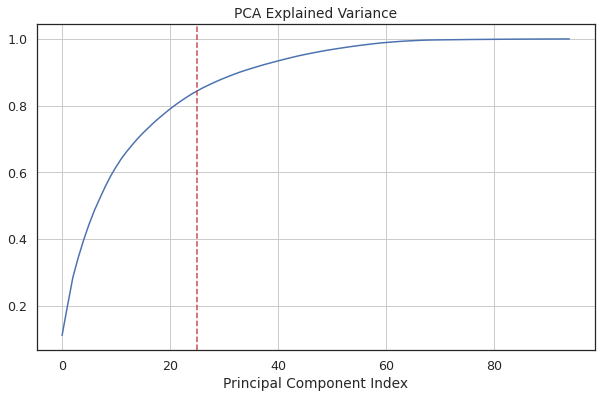

In [ ]:
pca = PCA().fit(imdb_work)
top_PCA=["%.2f" % a for a in pca.explained_variance_ratio_ if a >=0.01]

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.axvline(x=25, color = 'r', linestyle = '--', )
plt.xlabel("Principal Component Index")
#plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
sns.set_style('white')

### PC 1 features

In [ ]:
pca_1 = pca.components_[0]
pca_1_df = pd.DataFrame(zip(pca_1,imdb_work.columns), columns = ['Weights','Features'])
pca_1_df['Weights'] = abs(pca_1_df['Weights'])
pca_1_df.sort_values('Weights', ascending = False)[:10]

Weights   Features
19  0.464043      Drama
94  0.419303          R
14  0.374413  Adventure
1   0.280724       long
2   0.247799     normal
91  0.228837         PG
17  0.228577     Comedy
18  0.227451      Crime
15  0.209527  Animation
0   0.166900       Year

findfont: Font family ['calibri light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri light'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



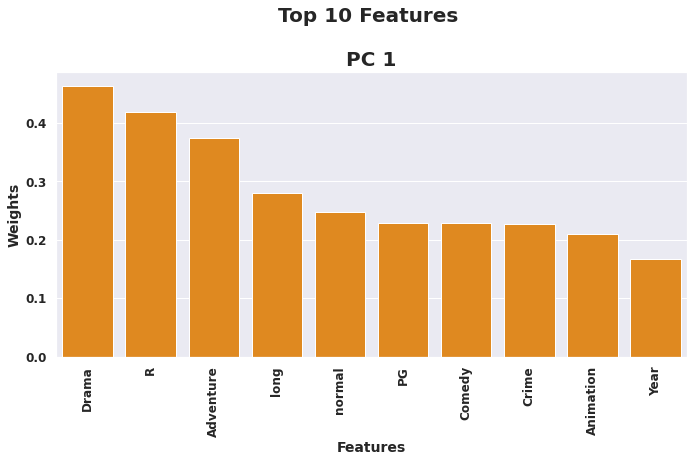

In [ ]:
# PC1 feature importance
top_features = pca_1_df.sort_values('Weights', ascending = False)[:10]

plt.figure(figsize=(10,6))
sns.set(font_scale = 1.3)
plt.rc('font', family='calibri light')
plt.title("Top 10 Features \n\n PC 1 ",fontsize=20, weight='bold')
plt.xticks(rotation=90, weight='bold',fontsize=12)
plt.yticks(weight='bold',fontsize=12)
plt.xlabel("Features",weight='bold',fontsize=14)
plt.ylabel("Weights",weight='bold',fontsize=14)
#plt.barh(x,y)
plt.tight_layout()
sns.barplot(top_features["Features"],top_features["Weights"],color='#ff8c00')
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



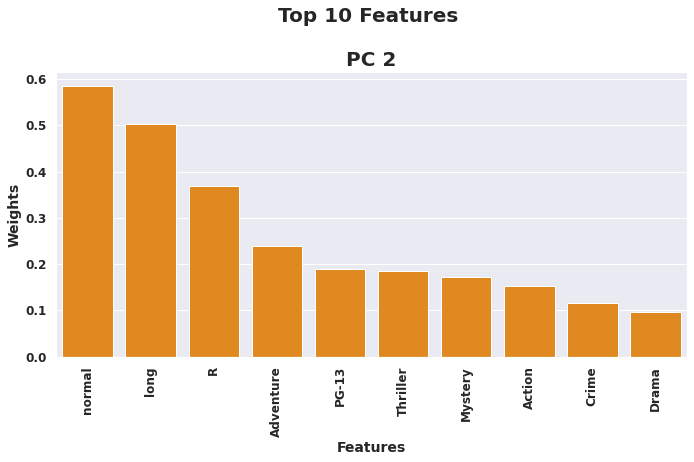

In [ ]:
# PC2 feature importance
pca_2 = pca.components_[1]
pca_2_df = pd.DataFrame(zip(pca_2,imdb_work.columns), columns = ['Weights','Features'])
pca_2_df['Weights'] = abs(pca_2_df['Weights'])
pca_2_df.sort_values('Weights', ascending = False)[:10]

top_features = pca_2_df.sort_values('Weights', ascending = False)[:10]

plt.figure(figsize=(10,6))
sns.set(font_scale = 1.3)
plt.rc('font', family='calibri light')
plt.title("Top 10 Features \n\n PC 2 ",fontsize=20, weight='bold')
plt.xticks(rotation=90, weight='bold',fontsize=12)
plt.yticks(weight='bold',fontsize=12)
plt.xlabel("Features",weight='bold',fontsize=14)
plt.ylabel("Weights",weight='bold',fontsize=14)
plt.tight_layout()
sns.barplot(top_features["Features"],top_features["Weights"],color='#ff8c00')
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



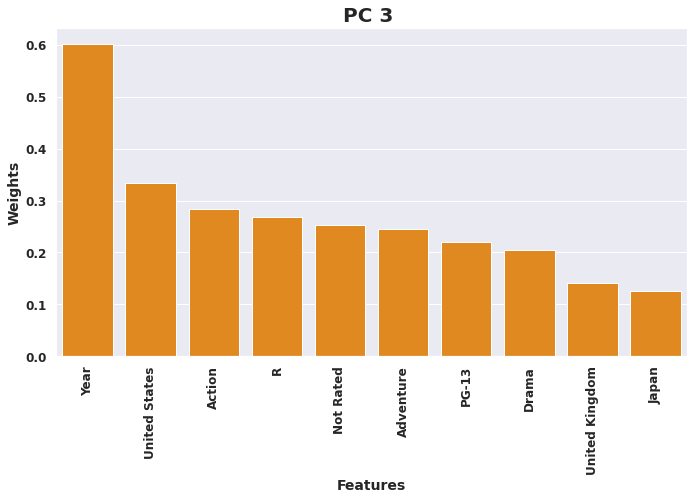

In [ ]:
# PC3 feature importance
pca_3 = pca.components_[2]
pca_3_df = pd.DataFrame(zip(pca_3,imdb_work.columns), columns = ['Weights','Features'])
pca_3_df['Weights'] = abs(pca_3_df['Weights'])
pca_3_df.sort_values('Weights', ascending = False)[:10]

top_features = pca_3_df.sort_values('Weights', ascending = False)[:10]

plt.figure(figsize=(10,6))
sns.set(font_scale = 1.3)
plt.rc('font', family='calibri light')
plt.title("PC 3 ",fontsize=20, weight='bold')
plt.xticks(rotation=90, weight='bold',fontsize=12)
plt.yticks(weight='bold',fontsize=12)
plt.xlabel("Features",weight='bold',fontsize=14)
plt.ylabel("Weights",weight='bold',fontsize=14)
plt.tight_layout()
sns.barplot(top_features["Features"],top_features["Weights"],color='#ff8c00')
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



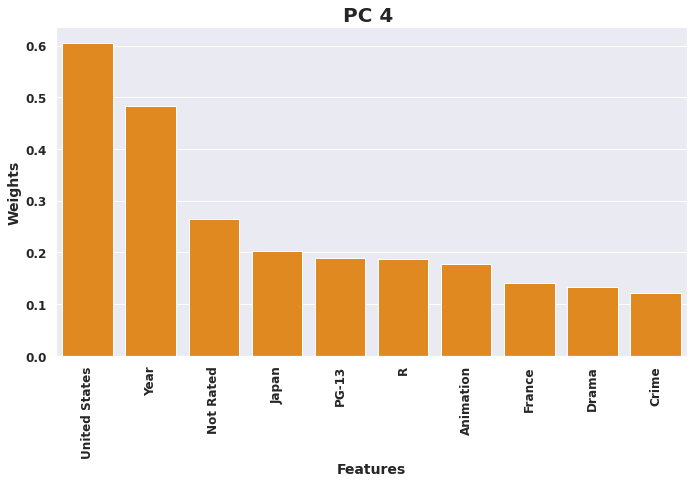

In [ ]:
# PC4 feature importance
pca_4 = pca.components_[3]
pca_4_df = pd.DataFrame(zip(pca_4,imdb_work.columns), columns = ['Weights','Features'])
pca_4_df['Weights'] = abs(pca_4_df['Weights'])
pca_4_df.sort_values('Weights', ascending = False)[:10]

top_features = pca_4_df.sort_values('Weights', ascending = False)[:10]

plt.figure(figsize=(10,6))
sns.set(font_scale = 1.3)
plt.rc('font', family='calibri light')
plt.title("PC 4 ",fontsize=20, weight='bold')
plt.xticks(rotation=90, weight='bold',fontsize=12)
plt.yticks(weight='bold',fontsize=12)
plt.xlabel("Features",weight='bold',fontsize=14)
plt.ylabel("Weights",weight='bold',fontsize=14)
plt.tight_layout()
sns.barplot(top_features["Features"],top_features["Weights"],color='#ff8c00')
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



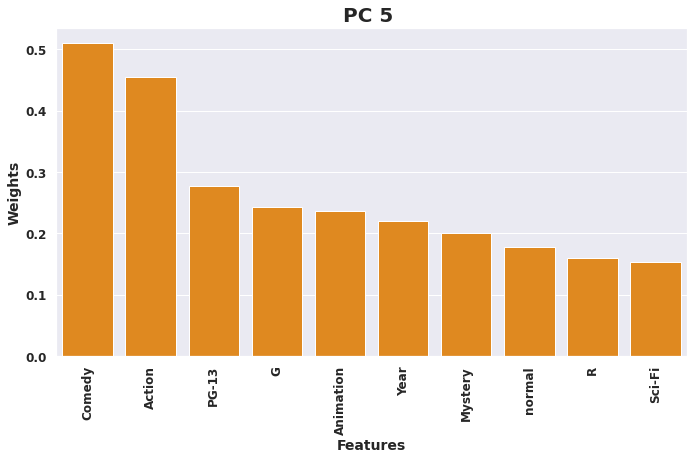

In [ ]:
# PC5 feature importance
pca_5 = pca.components_[4]
pca_5_df = pd.DataFrame(zip(pca_5,imdb_work.columns), columns = ['Weights','Features'])
pca_5_df['Weights'] = abs(pca_5_df['Weights'])
pca_5_df.sort_values('Weights', ascending = False)[:10]

top_features = pca_5_df.sort_values('Weights', ascending = False)[:10]

plt.figure(figsize=(10,6))
sns.set(font_scale = 1.3)
plt.rc('font', family='calibri light')
plt.title("PC 5 ",fontsize=20, weight='bold')
plt.xticks(rotation=90, weight='bold',fontsize=12)
plt.yticks(weight='bold',fontsize=12)
plt.xlabel("Features",weight='bold',fontsize=14)
plt.ylabel("Weights",weight='bold',fontsize=14)
plt.tight_layout()
sns.barplot(top_features["Features"],top_features["Weights"],color='#ff8c00')
sns.set_style('white')

### Transforming Original Data using PCA with 25 components

In [ ]:
pca_25 = PCA(n_components=25).fit(imdb_work)
imdb_work_pca = pca_25.transform(imdb_work)
pca_df = pd.DataFrame(imdb_work_pca, columns = [f'PC{i}' for i in range(1,26)], index = imdb['Title'])
pca_df.head()

PC1       PC2       PC3       PC4       PC5  \
Title                                                                        
The Shawshank Redemption -0.466820 -0.578680 -0.351936 -0.008329  0.166762   
The Godfather            -1.077857  0.530788  0.172208 -0.828393  0.141620   
The Dark Knight          -0.733614  1.143577 -0.910490  0.104957 -0.797319   
The Godfather: Part II   -1.149989  0.533367  0.161091 -0.904554  0.160756   
12 Angry Men             -0.091044 -0.184001  0.559593 -0.524364 -0.315608   

                               PC6       PC7       PC8       PC9      PC10  \
Title                                                                        
The Shawshank Redemption -0.147636  0.182398 -0.529349 -0.162079 -0.199385   
The Godfather             0.245032 -0.638207  0.136576  0.293969 -0.268401   
The Dark Knight          -0.504857  0.013901  1.096668  0.633059  0.290233   
The Godfather: Part II    0.263403 -0.708371  0.150545  0.330630 -0.369631   
12 Angry Men             -0.637299 -0.316105  0.249672  0.231615 -0.462215   

                          ...      PC16      PC17      PC18      PC19  \
Title                     ...                                           
The Shawshank Redemption  ...  0.004660  0.222211 -0.134784 -0.003770   
The Godfather             ...  0.056397  0.111796  0.006014 -0.098256   
The Dark Knight           ...  0.063823  0.123845  0.250738  0.076867   
The Godfather: Part II    ... -0.017820  0.048321  0.095292 -0.235334   
12 Angry Men              ...  0.081722 -0.245025  0.020342  0.313201   

                              PC20      PC21      PC22      PC23      PC24  \
Title                                                                        
The Shawshank Redemption -0.119103  0.047490  0.002080 -0.018414 -0.076087   
The Godfather            -0.048337  0.063085 -0.020709  0.090601 -0.123243   
The Dark Knight          -0.171251  0.114341  0.038255 -0.282413  0.114199   
The Godfather: Part II   -0.150531  0.120497 -0.017830  0.145700 -0.320294   
12 Angry Men             -0.026033  0.074576  0.513664  0.378629  0.039060   

                              PC25  
Title                               
The Shawshank Redemption -0.145709  
The Godfather            -0.155169  
The Dark Knight          -0.141835  
The Godfather: Part II    0.119791  
12 Angry Men             -0.267000  

[5 rows x 25 columns]

In [ ]:
pca_1 = pca_25.components_.sum(axis=1)
pca_1_df = pd.DataFrame(zip(pca_1,imdb_work.columns), columns = ['Weights','Features'])
pca_1_df['Weights'] = abs(pca_1_df['Weights'])
pca_1_df.sort_values('Weights', ascending = False)[:20]

Weights       Features
2   1.210960         normal
23  1.076932        History
15  0.882236      Animation
18  0.861324          Crime
21  0.812623        Fantasy
7   0.779952          India
20  0.649588         Family
13  0.613342         Action
16  0.592669      Biography
22  0.521702      Film-Noir
14  0.471232      Adventure
24  0.437739         Horror
19  0.343209          Drama
12  0.339447  United States
17  0.310854         Comedy
6   0.308768        Germany
0   0.298551           Year
3   0.224219      Australia
9   0.167588          Japan
10  0.166287          Spain

Text(0, 0.5, 'Weights')

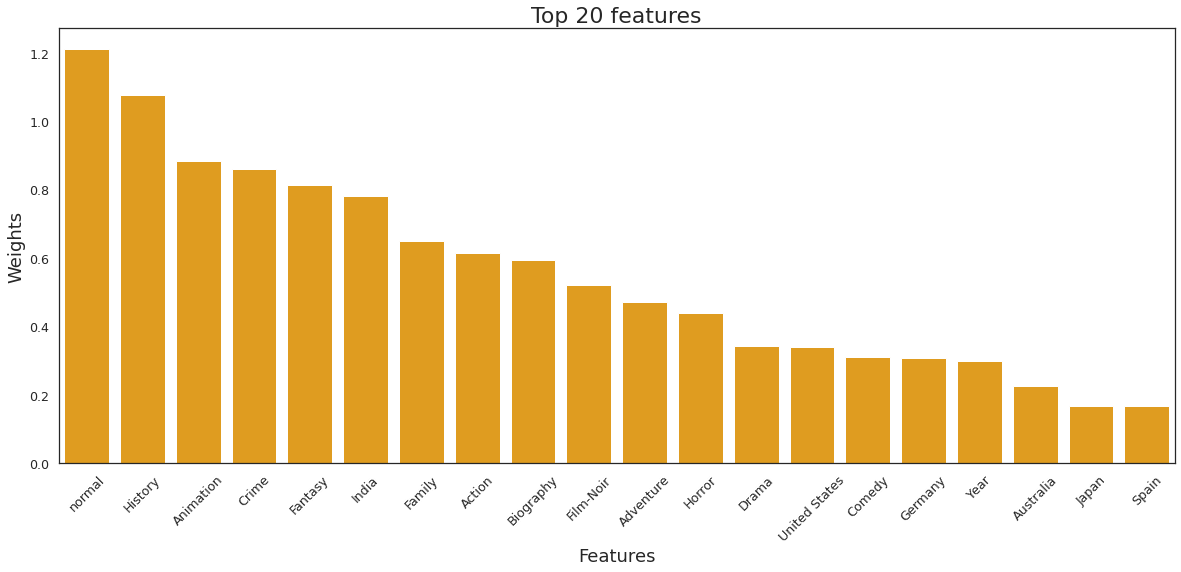

In [ ]:
plt.figure(figsize = (20,8))
sns.barplot(x='Features', y='Weights', data=pca_1_df.sort_values('Weights',ascending=False).iloc[:20,:], color='orange')
plt.xticks(rotation=45)
plt.title('Top 20 features', fontsize=22)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Weights', fontsize=18)

## Clustering


### Kmeans

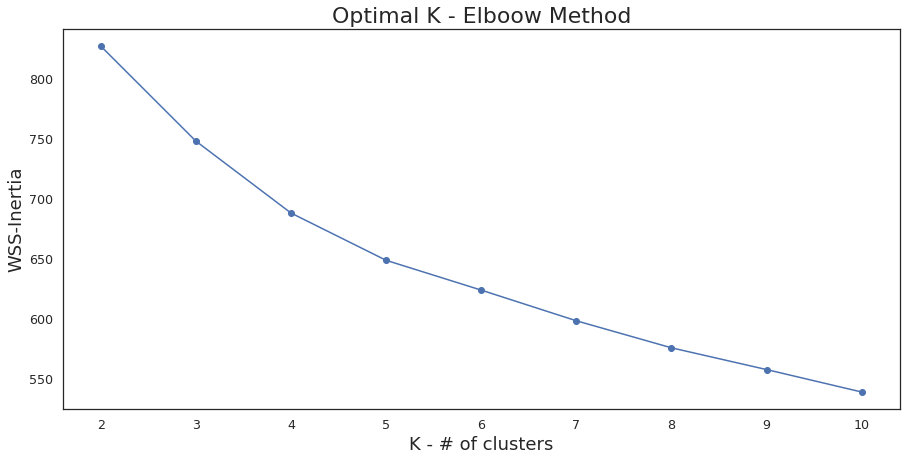

In [ ]:
# Finding Optimal K
# Elbow Method - Inertia
inertia = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state = 100)
    km = km.fit(imdb_work_pca )
    inertia.append(km.inertia_)
plt.figure(figsize=(15,7))
plt.plot(K,inertia, 'o-') # k = 4 or 5
plt.xlabel("K - # of clusters",fontsize=18)
plt.ylabel("WSS-Inertia", fontsize=18)
plt.title("Optimal K - Elboow Method", fontsize=22)
plt.savefig('K-Elbow.png')
plt.show()

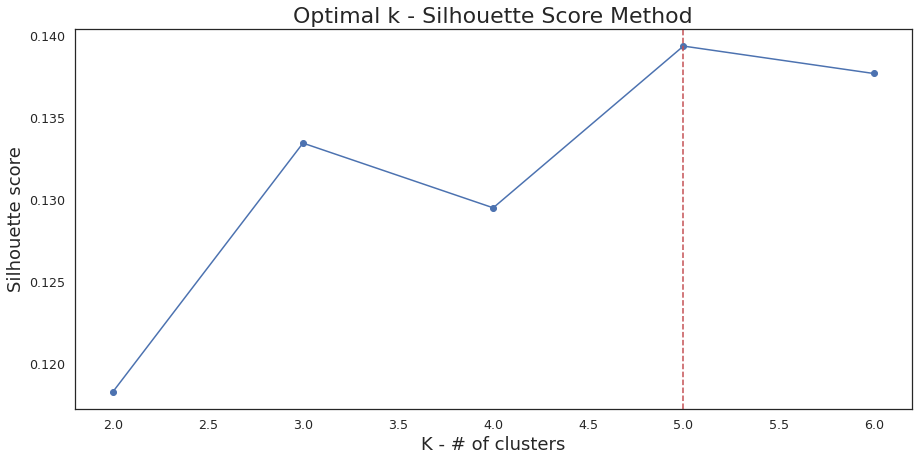

In [ ]:
# Silhouette Score
SW = []
K = range(2,7)
for k in K:
    KM=KMeans(n_clusters=k, random_state = 100)
    KM.fit(imdb_work_pca)
    SW.append(silhouette_score(imdb_work_pca, KM.labels_, metric='euclidean'))

plt.figure(figsize=(15,7))
plt.plot(K,SW, 'o-') # k = 4 or 5
plt.xlabel("K - # of clusters",fontsize=18)
plt.ylabel("Silhouette score", fontsize=18)
plt.title("Optimal k - Silhouette Score Method", fontsize=22)
plt.axvline(x=5, color = 'r', linestyle = '--', )
plt.savefig('K-SW.png')
plt.show()
# k = 5

In [ ]:
#Clustering with kmeans as k=5
from sklearn.cluster import MiniBatchKMeans
km=MiniBatchKMeans(n_clusters=5,init='k-means++',max_iter=500,n_init=1000,init_size=1000,batch_size=1000,
                  verbose=False, random_state=5621)
km_model=km.fit(imdb_work_pca)
kmeanlabels=km.labels_
kmeanclusters = km.predict(imdb_work_pca)
kmeandistances = km.transform(imdb_work_pca)

In [ ]:
imdb_work['Cluster_Labels'] = kmeanlabels
imdb['Cluster_Labels'] = kmeanlabels
imdb_work['Cluster_Labels'].value_counts() #number of films per cluster (clusters from 0 to 4)

0    100
1     60
3     35
4     34
2     21
Name: Cluster_Labels, dtype: int64

#### K Means Cluster Characteristics

In [ ]:
imdb_work[imdb_work['Cluster_Labels'] == 0].index

Index(['The Shawshank Redemption', 'The Godfather', 'The Godfather: Part II',
       'Schindler's List', 'Pulp Fiction', 'Fight Club', 'The Matrix',
       'Goodfellas', 'One Flew Over the Cuckoo's Nest', 'Se7en',
       'The Silence of the Lambs', 'Saving Private Ryan', 'City of God',
       'The Green Mile', 'Terminator 2: Judgment Day', 'Psycho',
       'Léon: The Professional', 'The Pianist', 'Parasite',
       'American History X', 'The Usual Suspects', 'The Departed', 'Whiplash',
       'The Intouchables', 'Alien', 'Memento', 'Apocalypse Now',
       'Django Unchained', 'The Lives of Others', 'The Shining', 'Aliens',
       'American Beauty', 'Joker', 'Old Boy', 'Braveheart',
       'Inglourious Basterds', 'The Boat', 'Once Upon a Time in America',
       'Good Will Hunting', 'Requiem for a Dream', 'Reservoir Dogs',
       'Eternal Sunshine of the Spotless Mind', 'Capernaum', 'The Hunt',
       'Amélie', 'Full Metal Jacket', 'Scarface', 'Taxi Driver',
       'L.A. Confidential', 

In [ ]:
imdb_work[imdb_work['Cluster_Labels'] == 1].index

Index(['12 Angry Men', 'Star Wars: Episode V - The Empire Strikes Back',
       'It's a Wonderful Life', 'Star Wars', 'Back to the Future',
       'Casablanca', 'Modern Times', 'Rear Window', 'City Lights',
       'Indiana Jones and the Raiders of the Lost Ark', 'Sunset Blvd.',
       'Paths of Glory', 'The Great Dictator', 'Witness for the Prosecution',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb',
       'Amadeus', 'Singin' in the Rain',
       'Star Wars: Episode VI - Return of the Jedi', '2001: A Space Odyssey',
       'Citizen Kane', 'M', 'North by Northwest', 'Vertigo',
       'A Clockwork Orange', 'Double Indemnity', 'The Apartment',
       'To Kill a Mockingbird', 'The Sting', 'The Kid', 'Some Like It Hot',
       'All About Eve', 'Judgment at Nuremberg',
       'Monty Python and the Holy Grail', 'The Truman Show',
       'The Treasure of the Sierra Madre', 'The Great Escape',
       'The Elephant Man', 'Gone with the Wind', 'Dial M for Murder',

In [ ]:
imdb_work[imdb_work['Cluster_Labels'] == 2].index

Index(['Spirited Away', 'The Lion King', 'WALL·E',
       'Spider-Man: Into the Spider-Verse', 'Toy Story', 'Coco',
       'Princess Mononoke', 'Toy Story 3', 'Up', 'Finding Nemo', 'Inside Out',
       'Howl's Moving Castle', 'My Neighbor Totoro',
       'How to Train Your Dragon', 'Klaus', 'Monsters, Inc.',
       'The Wizard of Oz', 'Ratatouille', 'The Incredibles', 'Aladdin',
       'Beauty and the Beast'],
      dtype='object', name='Title')

In [ ]:
imdb_work[imdb_work['Cluster_Labels'] == 3].index

Index(['The Dark Knight', 'The Lord of the Rings: The Return of the King',
       'The Lord of the Rings: The Fellowship of the Ring', 'Forrest Gump',
       'Inception', 'The Lord of the Rings: The Two Towers', 'Interstellar',
       'Gladiator', 'The Prestige', 'Once Upon a Time in the West',
       'Avengers: Infinity War', 'The Dark Knight Rises',
       'Spider-Man: No Way Home', 'Avengers: Endgame', '3 Idiots', 'Hamilton',
       'Indiana Jones and the Last Crusade', 'A Separation', 'Batman Begins',
       'Dangal', 'The Batman', 'The Father', 'Green Book', 'A Beautiful Mind',
       'The Sixth Sense', 'Jurassic Park', 'Warrior', 'Million Dollar Baby',
       'Catch Me If You Can', 'Harry Potter and the Deathly Hallows: Part 2',
       'Hotel Rwanda', 'Ford v Ferrari',
       'Pirates of the Caribbean: The Curse of the Black Pearl', 'Dune',
       'The Help'],
      dtype='object', name='Title')

In [ ]:
imdb_work[imdb_work['Cluster_Labels'] == 4].index

Index(['The Good, the Bad and the Ugly', 'Seven Samurai', 'Life Is Beautiful',
       'Hara-Kiri', 'Grave of the Fireflies', 'Cinema Paradiso', 'Your Name.',
       'High and Low', 'Lawrence of Arabia', 'Come and See', 'Ikiru',
       'Metropolis', 'Bicycle Thieves', 'Like Stars on Earth',
       'For a Few Dollars More', 'Ran', 'Yojimbo', 'Rashomon',
       'Children of Heaven', 'Wild Strawberries', 'Pather Panchali',
       'The Wages of Fear', 'Memories of Murder', 'The Seventh Seal',
       'Mary and Max', 'The Passion of Joan of Arc', 'Tokyo Story',
       'Dersu Uzala', 'My Father and My Son', 'The Battle of Algiers',
       'The 400 Blows', 'Persona', 'The Handmaiden', 'Jai Bhim'],
      dtype='object', name='Title')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



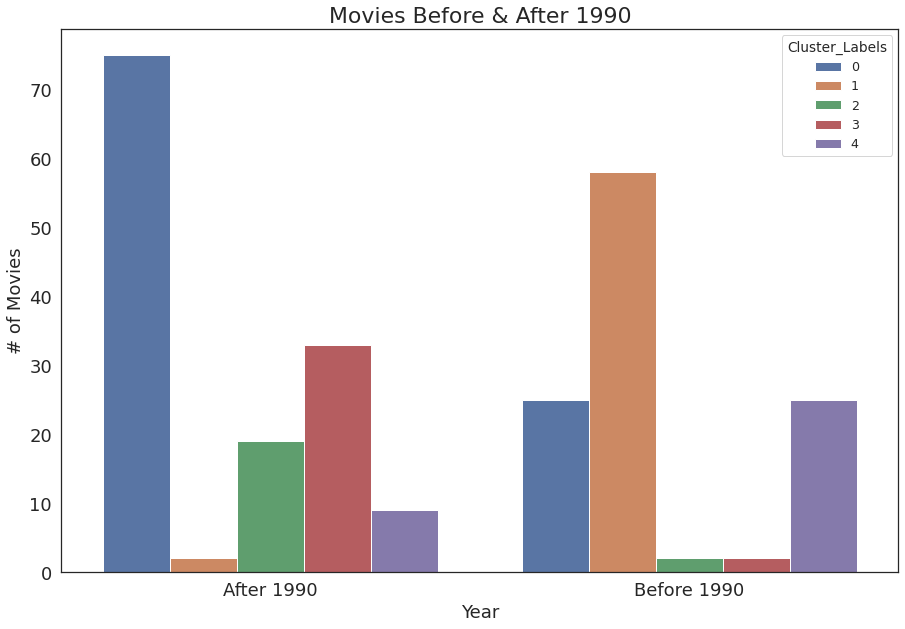

In [ ]:
# Year
plt.figure(figsize = (15,10))
sns.countplot(imdb_work['Year'].apply(lambda x: 'Before 1990' if x==0 else 'After 1990'),hue=imdb_work['Cluster_Labels'])
plt.title('Movies Before & After 1990', fontsize=22)
plt.xlabel('Year', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

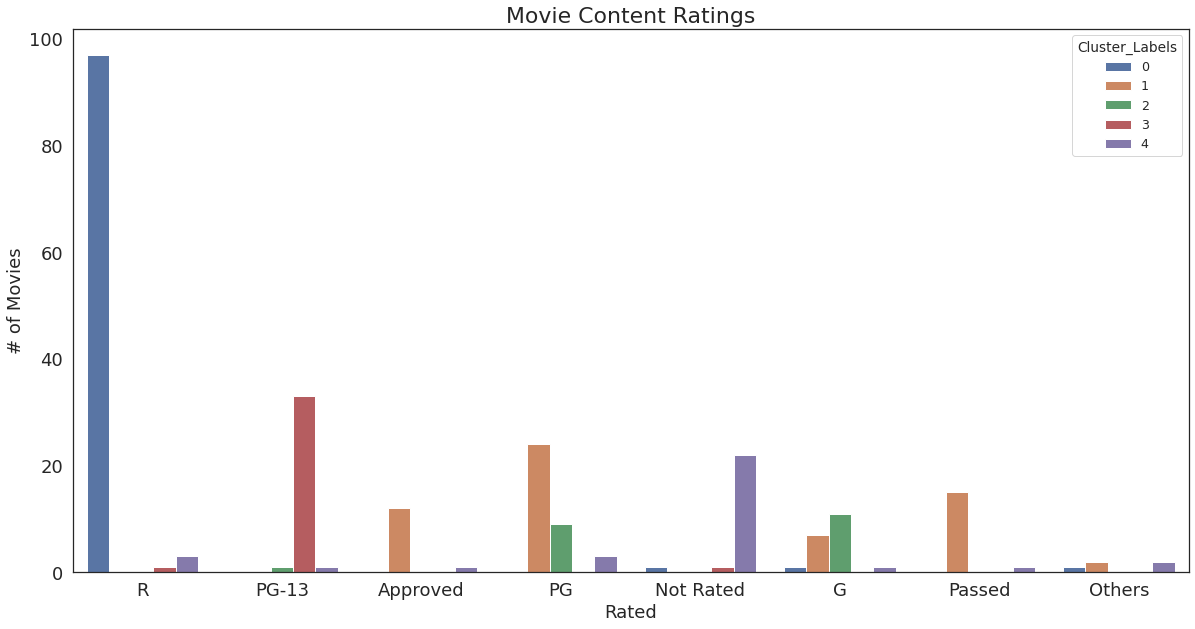

In [ ]:
# Rated

plt.figure(figsize=(20,10))
sns.countplot(x = imdb['Rated_Cat'],hue=imdb['Cluster_Labels'])
plt.title('Movie Content Ratings', fontsize=22)
plt.xlabel('Rated', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



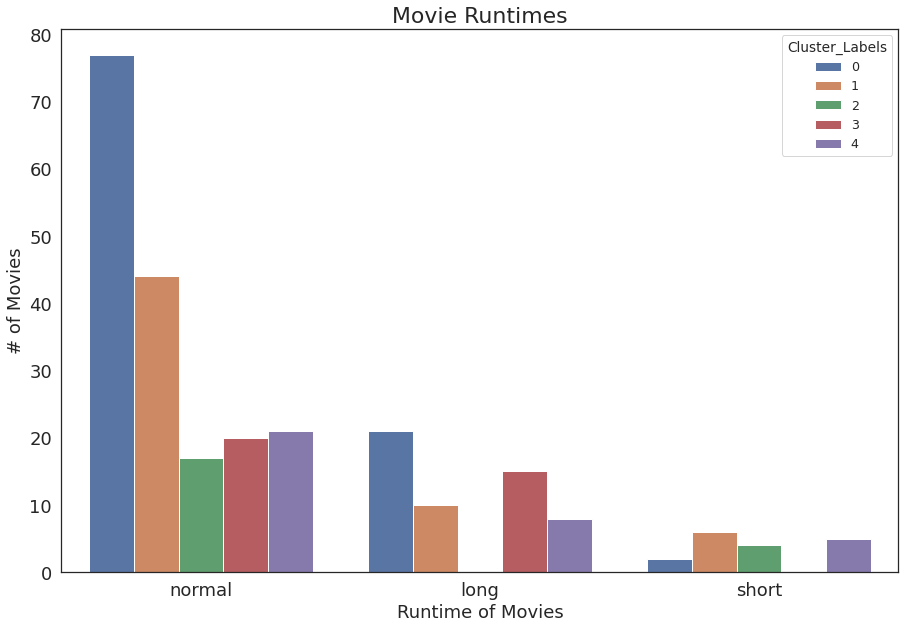

In [ ]:
# Runtime
plt.figure(figsize=(15,10))
sns.countplot(imdb['Runtime_bin'],hue=imdb['Cluster_Labels'])
plt.title('Movie Runtimes', fontsize=22)
plt.xlabel('Runtime of Movies', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
# Genre
# Since top 250 movies are mostly Drama, so it is a generic genre for most of the movies.
genre_df[imdb['Cluster_Labels'] == 0].sum(axis=0).sort_values(ascending=False).head() 
#Adventure Animation

Drama       80
Crime       32
Thriller    17
Action      16
Mystery     15
dtype: int64

In [ ]:
genre_df[imdb['Cluster_Labels'] == 1].sum(axis=0).sort_values(ascending=False).head() 
# Crime & Mystery Thrillers Dramas

Drama        38
Comedy       20
Adventure    16
Romance      12
Crime        10
dtype: int64

In [ ]:
genre_df[imdb['Cluster_Labels'] == 2].sum(axis=0).sort_values(ascending=False).head()
# Action Adventure Crime Movies

Animation    20
Adventure    19
Comedy       11
Family        6
Action        4
dtype: int64

In [ ]:
genre_df[imdb['Cluster_Labels'] == 3].sum(axis=0).sort_values(ascending=False).head()
# Drama Movies

Drama        27
Action       19
Adventure    14
Biography     7
Crime         5
dtype: int64

In [ ]:
genre_df[imdb['Cluster_Labels'] == 4].sum(axis=0).sort_values(ascending=False).head()
# Animation Movies

Drama       32
Mystery      5
Crime        5
Thriller     5
Action       4
dtype: int64

In [ ]:
# Director
dir_df[imdb['Cluster_Labels'] == 0].sum(axis=0).sort_values(ascending=False)

Martin Scorsese      7
Quentin Tarantino    5
Stanley Kubrick      2
Steven Spielberg     2
Alfred Hitchcock     1
Christopher Nolan    1
Sergio Leone         1
Akira Kurosawa       0
Billy Wilder         0
Charles Chaplin      0
Hayao Miyazaki       0
Lee Unkrich          0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_Labels'] == 1].sum(axis=0).sort_values(ascending=False)

Alfred Hitchcock     5
Billy Wilder         5
Charles Chaplin      5
Stanley Kubrick      5
Steven Spielberg     2
Akira Kurosawa       0
Christopher Nolan    0
Hayao Miyazaki       0
Lee Unkrich          0
Martin Scorsese      0
Quentin Tarantino    0
Sergio Leone         0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_Labels'] == 2].sum(axis=0).sort_values(ascending=False)

Hayao Miyazaki       4
Lee Unkrich          4
Akira Kurosawa       0
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Christopher Nolan    0
Martin Scorsese      0
Quentin Tarantino    0
Sergio Leone         0
Stanley Kubrick      0
Steven Spielberg     0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_Labels'] == 3].sum(axis=0).sort_values(ascending=False)

Christopher Nolan    6
Steven Spielberg     3
Sergio Leone         1
Akira Kurosawa       0
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Hayao Miyazaki       0
Lee Unkrich          0
Martin Scorsese      0
Quentin Tarantino    0
Stanley Kubrick      0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_Labels'] == 4].sum(axis=0).sort_values(ascending=False)

Akira Kurosawa       7
Sergio Leone         2
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Christopher Nolan    0
Hayao Miyazaki       0
Lee Unkrich          0
Martin Scorsese      0
Quentin Tarantino    0
Stanley Kubrick      0
Steven Spielberg     0
dtype: int64

In [ ]:
# Actors
actors_df[imdb['Cluster_Labels'] == 0].sum(axis=0).sort_values(ascending=False)

Robert De Niro       9
Al Pacino            4
Jack Nicholson       4
Leonardo DiCaprio    4
Brad Pitt            4
Kevin Spacey         4
Matt Damon           3
Morgan Freeman       3
Clint Eastwood       2
Mark Ruffalo         2
Tom Hanks            2
Harrison Ford        1
James Stewart        0
Christian Bale       0
Charles Chaplin      0
Tatsuya Nakadai      0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_Labels'] == 1].sum(axis=0).sort_values(ascending=False)

Charles Chaplin      5
Harrison Ford        4
James Stewart        4
Al Pacino            0
Mark Ruffalo         0
Tom Hanks            0
Tatsuya Nakadai      0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Kevin Spacey         0
Leonardo DiCaprio    0
Brad Pitt            0
Jack Nicholson       0
Clint Eastwood       0
Christian Bale       0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_Labels'] == 2].sum(axis=0).sort_values(ascending=False)

Tom Hanks            2
Al Pacino            0
Leonardo DiCaprio    0
Tatsuya Nakadai      0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Mark Ruffalo         0
Kevin Spacey         0
Brad Pitt            0
James Stewart        0
Jack Nicholson       0
Harrison Ford        0
Clint Eastwood       0
Christian Bale       0
Charles Chaplin      0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_Labels'] == 3].sum(axis=0).sort_values(ascending=False)

Christian Bale       5
Tom Hanks            2
Leonardo DiCaprio    2
Mark Ruffalo         2
Matt Damon           1
Clint Eastwood       1
Harrison Ford        1
Morgan Freeman       1
Al Pacino            0
Tatsuya Nakadai      0
Robert De Niro       0
Kevin Spacey         0
Brad Pitt            0
James Stewart        0
Jack Nicholson       0
Charles Chaplin      0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_Labels'] == 4].sum(axis=0).sort_values(ascending=False)

Toshirô Mifune       4
Tatsuya Nakadai      4
Clint Eastwood       2
Leonardo DiCaprio    0
Tom Hanks            0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Mark Ruffalo         0
Al Pacino            0
Brad Pitt            0
James Stewart        0
Jack Nicholson       0
Harrison Ford        0
Christian Bale       0
Charles Chaplin      0
Kevin Spacey         0
dtype: int64

In [ ]:
country_df[imdb['Cluster_Labels'] == 0].sum(axis=0).sort_values(ascending=False)

United States     80
United Kingdom    24
France            12
Germany           11
Spain              4
Australia          3
Canada             3
Italy              2
India              1
Japan              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_Labels'] == 1].sum(axis=0).sort_values(ascending=False)

United States     57
United Kingdom     9
France             1
Germany            1
India              1
Australia          0
Canada             0
Italy              0
Japan              0
Spain              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_Labels'] == 2].sum(axis=0).sort_values(ascending=False)

United States     16
Japan              4
Australia          1
Spain              1
United Kingdom     1
Canada             0
France             0
Germany            0
India              0
Italy              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_Labels'] == 3].sum(axis=0).sort_values(ascending=False)

United States     33
United Kingdom    10
Canada             3
France             2
India              2
Italy              2
Australia          1
Germany            0
Japan              0
Spain              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_Labels'] == 4].sum(axis=0).sort_values(ascending=False)

Japan             11
Italy              7
France             5
India              3
Spain              2
Australia          1
Germany            1
United Kingdom     1
Canada             0
United States      0
dtype: int64

In [ ]:
# Plot Words
plot_df[imdb['Cluster_Labels'] == 0].sum(axis=0).sort_values(ascending=False).head()

life     1.629135
man      1.300174
year     1.257649
young    1.190370
find     1.189347
dtype: float64

In [ ]:
plot_df[imdb['Cluster_Labels'] == 1].sum(axis=0).sort_values(ascending=False).head()

try         0.699516
murder      0.665665
help        0.656147
war         0.634799
american    0.582813
dtype: float64

In [ ]:
plot_df[imdb['Cluster_Labels'] == 2].sum(axis=0).sort_values(ascending=False).head()

young     0.770339
old       0.355182
new       0.343962
family    0.310285
child     0.306019
dtype: float64

In [ ]:
plot_df[imdb['Cluster_Labels'] == 3].sum(axis=0).sort_values(ascending=False).head()

work        0.600354
american    0.497319
man         0.461091
help        0.428186
force       0.397319
dtype: float64

In [ ]:
plot_df[imdb['Cluster_Labels'] == 4].sum(axis=0).sort_values(ascending=False).head()

find    0.988686
boy     0.640889
son     0.597150
life    0.521214
work    0.516104
dtype: float64

### Heirarchical Clusteing

In [ ]:
import scipy.cluster.hierarchy as shc


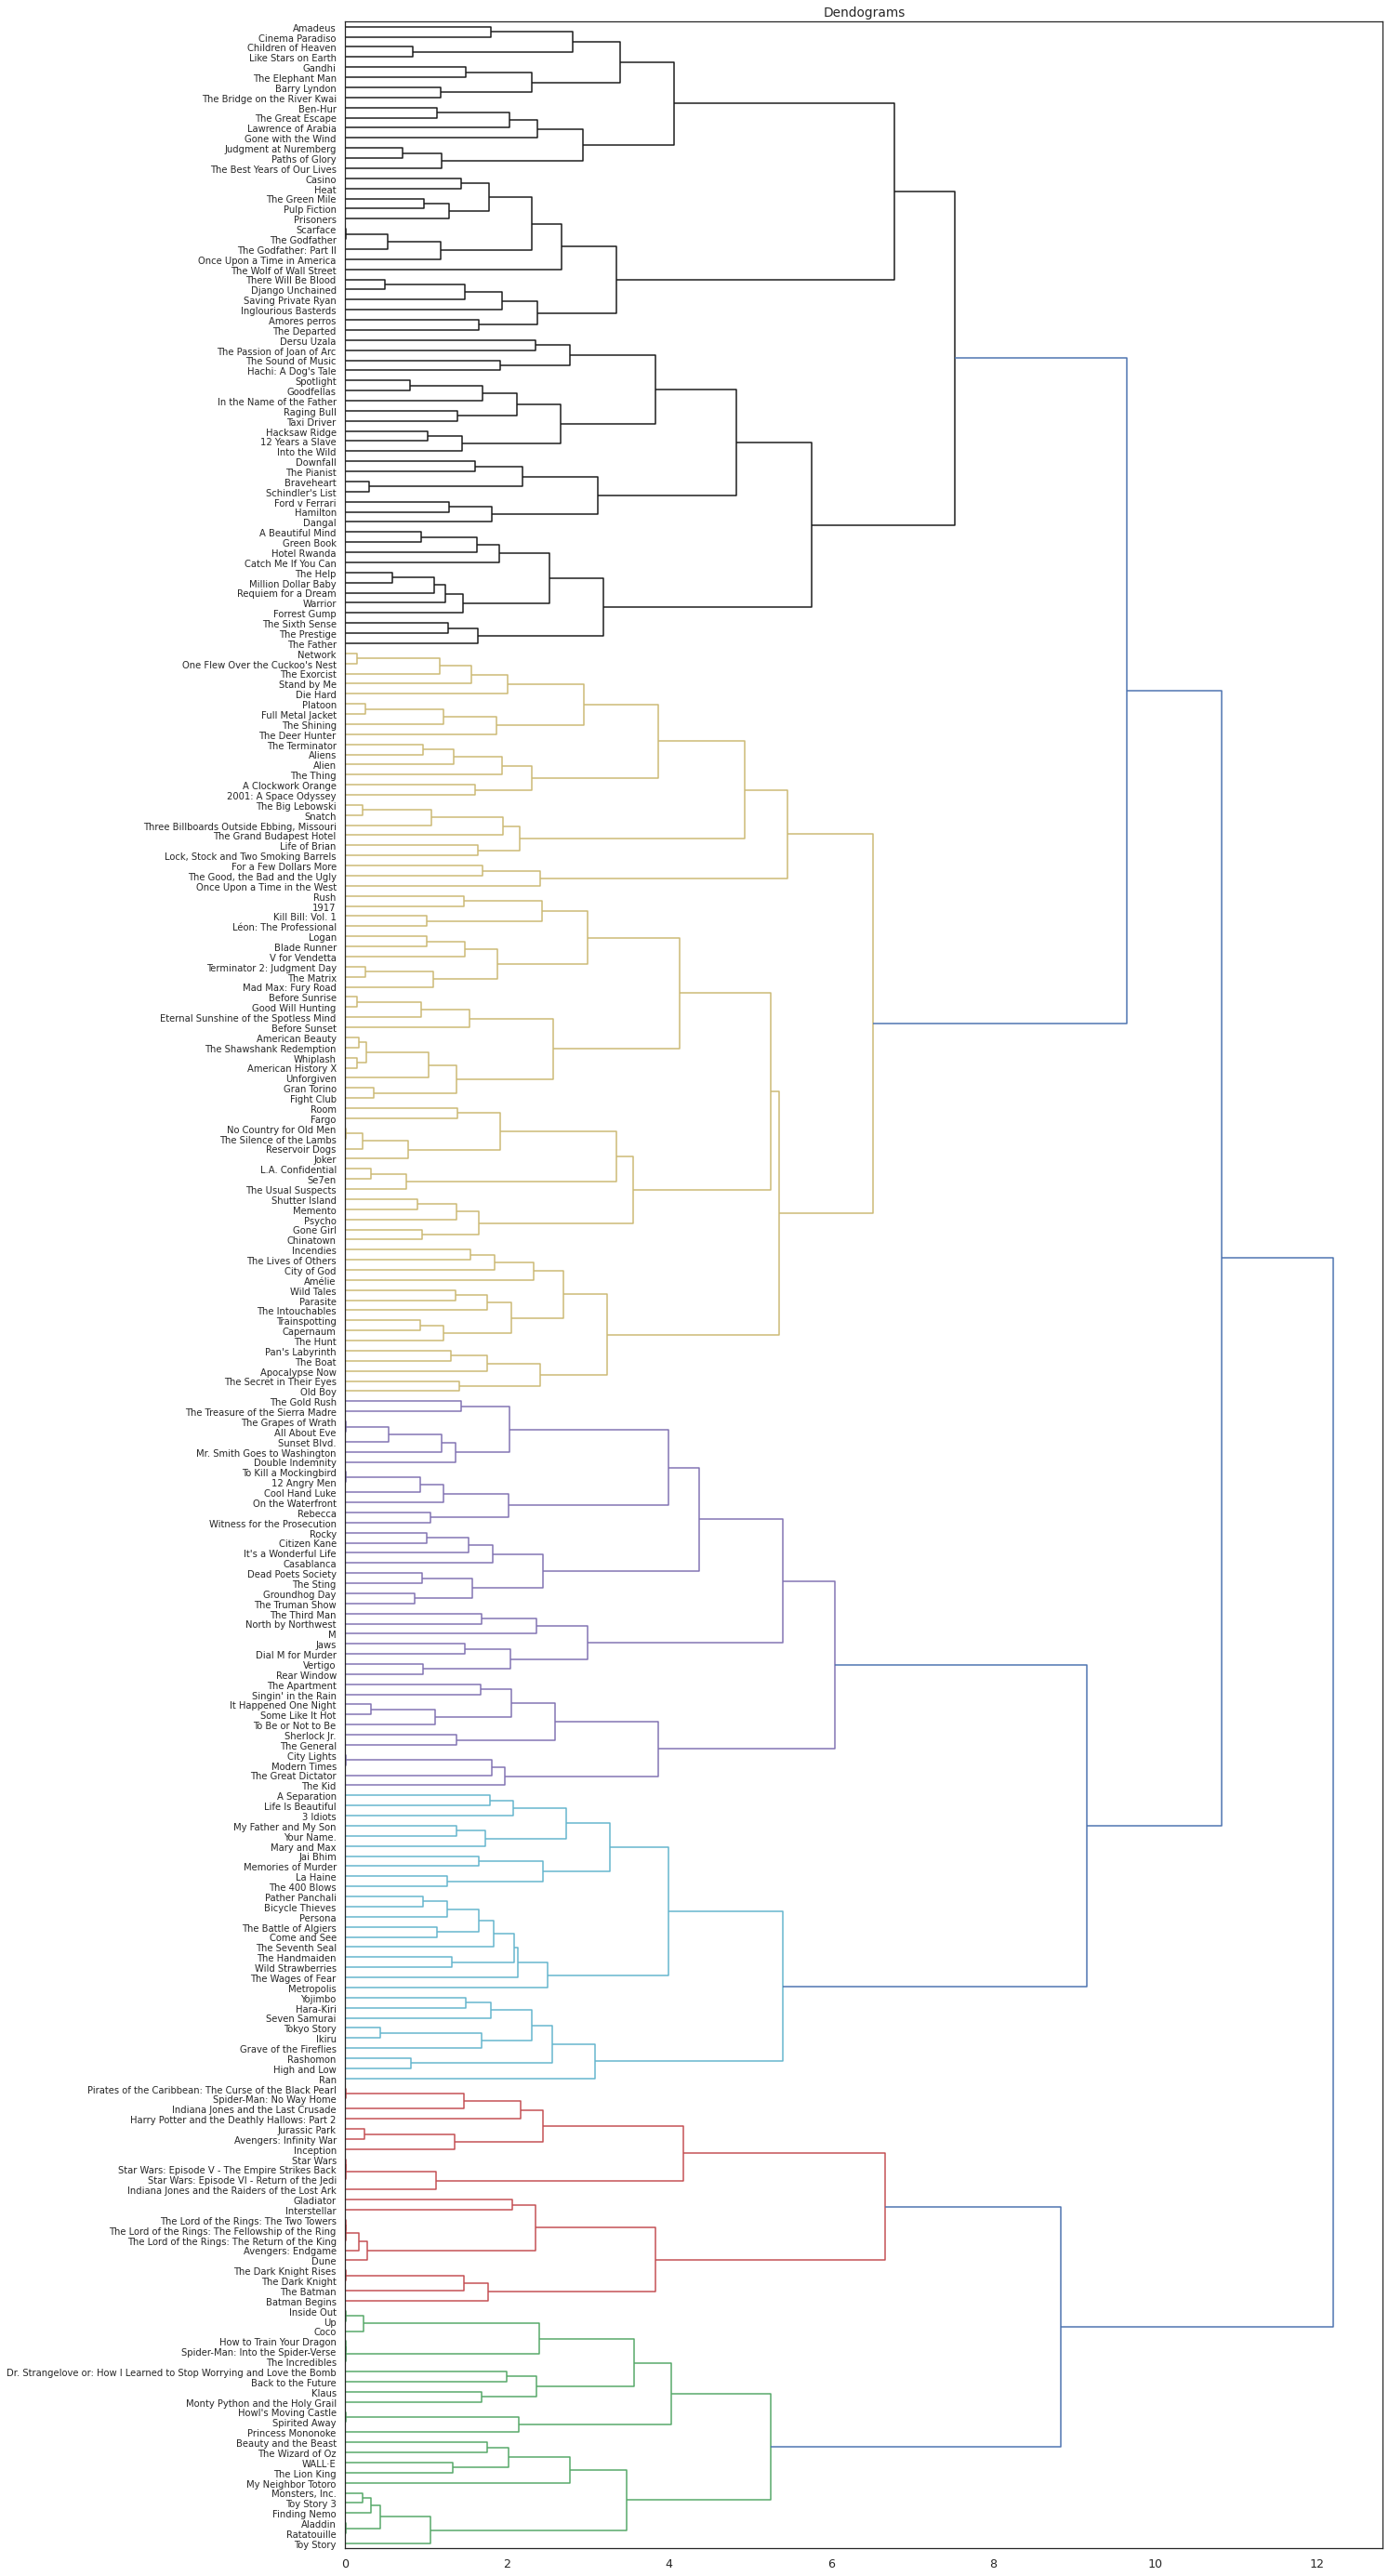

In [ ]:
plt.figure(figsize=(20,50))
plt.title('Dendograms')
dend = shc.dendrogram(shc.linkage(pca_df, method = 'ward'), 
                      labels = list(imdb_work.index),
                      leaf_font_size = 10,
                      orientation = 'right')
plt.savefig('dendo.png')

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agg = AgglomerativeClustering(n_clusters=6, affinity = "euclidean", linkage='ward')
Cluster_hc = agg.fit_predict(imdb_work_pca)
AgglomerativeClustering()

AgglomerativeClustering()

In [ ]:
SW = []
for k in {'ward', 'complete', 'average', 'single'}:
  ag = AgglomerativeClustering(n_clusters=6, affinity = "euclidean", linkage=k)
  Cluster_hc = ag.fit_predict(imdb_work_pca)
  SW.append(silhouette_score(imdb_work_pca, Cluster_hc, metric='euclidean'))
SW

[-0.0019633801051944437,
 0.07281792882076994,
 0.1001561773545201,
 0.11909089439604213]

In [ ]:
imdb['Cluster_hc_labels'] = Cluster_hc
imdb_work['Cluster_hc_labels'] = Cluster_hc

In [ ]:
imdb_work['Cluster_hc_labels'].value_counts()

1    74
0    62
3    39
4    29
5    24
2    22
Name: Cluster_hc_labels, dtype: int64

#### Cluster Characteristics

In [ ]:
# Titles
print("Cluster 0 : \n")
print(imdb_work[imdb_work['Cluster_hc_labels'] == 0].index)
print("\nCluster 1 : \n")
print(imdb_work[imdb_work['Cluster_hc_labels'] == 1].index)
print("\nCluster 2 : \n")
print(imdb_work[imdb_work['Cluster_hc_labels'] == 2].index)
print("\nCluster 3 : \n")
print(imdb_work[imdb_work['Cluster_hc_labels'] == 3].index)
print("\nCluster 4 : \n")
print(imdb_work[imdb_work['Cluster_hc_labels'] == 4].index)
print("\nCluster 5 : \n")
print(imdb_work[imdb_work['Cluster_hc_labels'] == 5].index)

Cluster 0 : 

Index(['The Godfather', 'The Godfather: Part II', 'Schindler's List',
       'Pulp Fiction', 'Forrest Gump', 'Goodfellas', 'Saving Private Ryan',
       'The Green Mile', 'The Pianist', 'The Departed', 'The Prestige',
       'Cinema Paradiso', 'Django Unchained', 'Paths of Glory', 'Braveheart',
       'Amadeus', 'Inglourious Basterds', 'Once Upon a Time in America',
       'Requiem for a Dream', 'Lawrence of Arabia', 'Scarface', 'Taxi Driver',
       'Hamilton', 'Heat', 'Like Stars on Earth', 'Dangal', 'Downfall',
       'The Father', 'The Wolf of Wall Street', 'Green Book', 'Casino',
       'Judgment at Nuremberg', 'A Beautiful Mind', 'The Sixth Sense',
       'There Will Be Blood', 'The Great Escape', 'Raging Bull',
       'The Elephant Man', 'Gone with the Wind',
       'The Bridge on the River Kwai', 'Warrior', 'Prisoners',
       'Million Dollar Baby', 'Catch Me If You Can', 'Children of Heaven',
       '12 Years a Slave', 'Ben-Hur', 'In the Name of the Father',
    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text major ticklabel objects>)

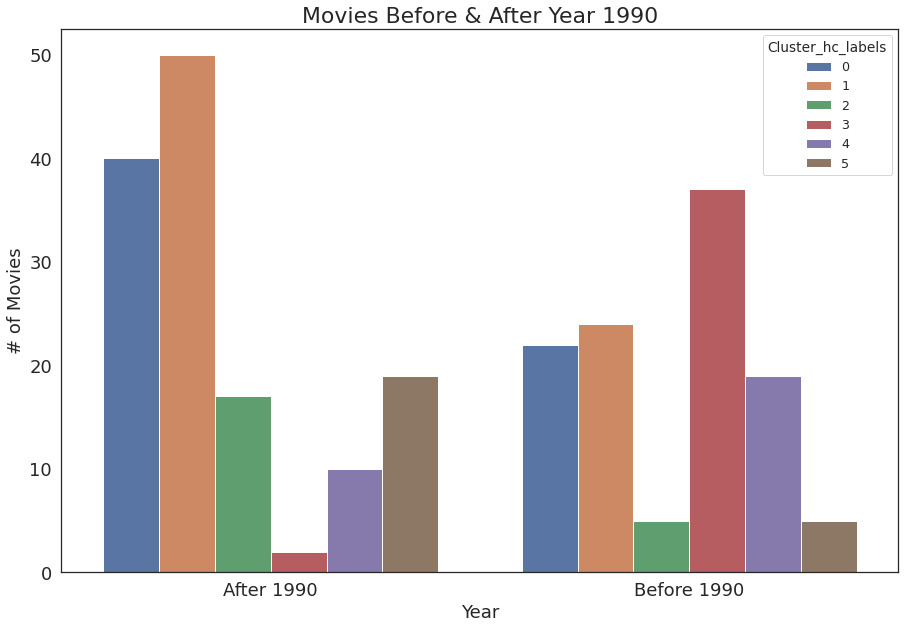

In [ ]:
# Year
plt.figure(figsize = (15,10))
sns.countplot(imdb_work['Year'].apply(lambda x: 'Before 1990' if x==0 else 'After 1990'),hue=imdb_work['Cluster_hc_labels'])
plt.title('Movies Before & After Year 1990', fontsize=22)
plt.xlabel('Year', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

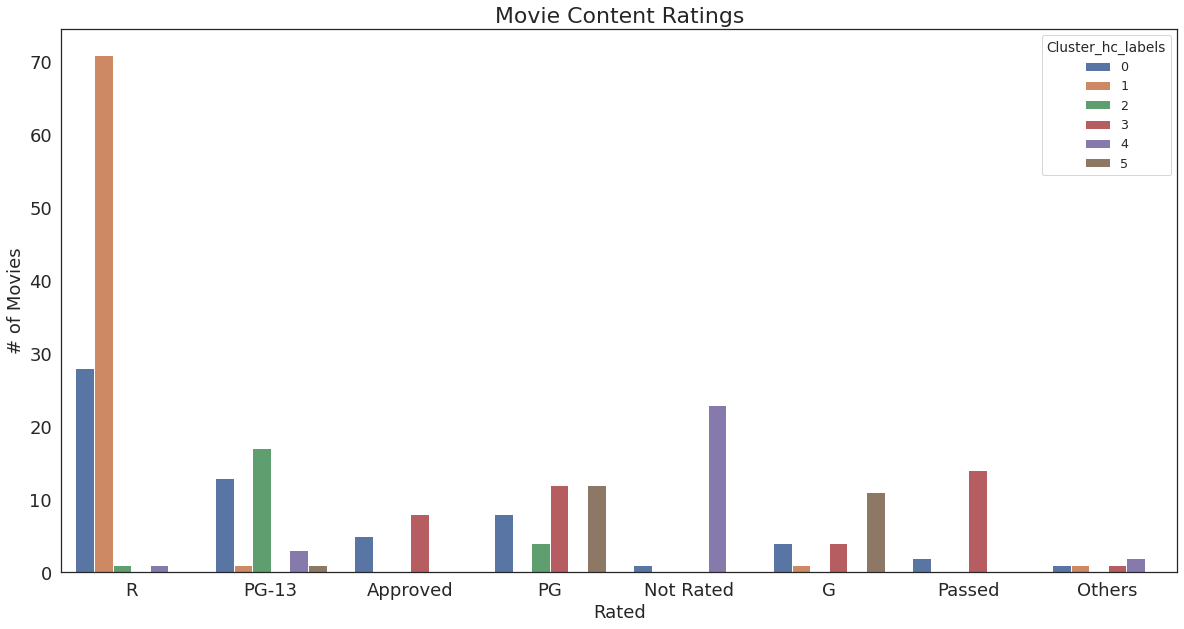

In [ ]:
# Rated
plt.figure(figsize=(20,10))
sns.countplot(x = imdb['Rated_Cat'],hue=imdb['Cluster_hc_labels'])
plt.title('Movie Content Ratings', fontsize=22)
plt.xlabel('Rated', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



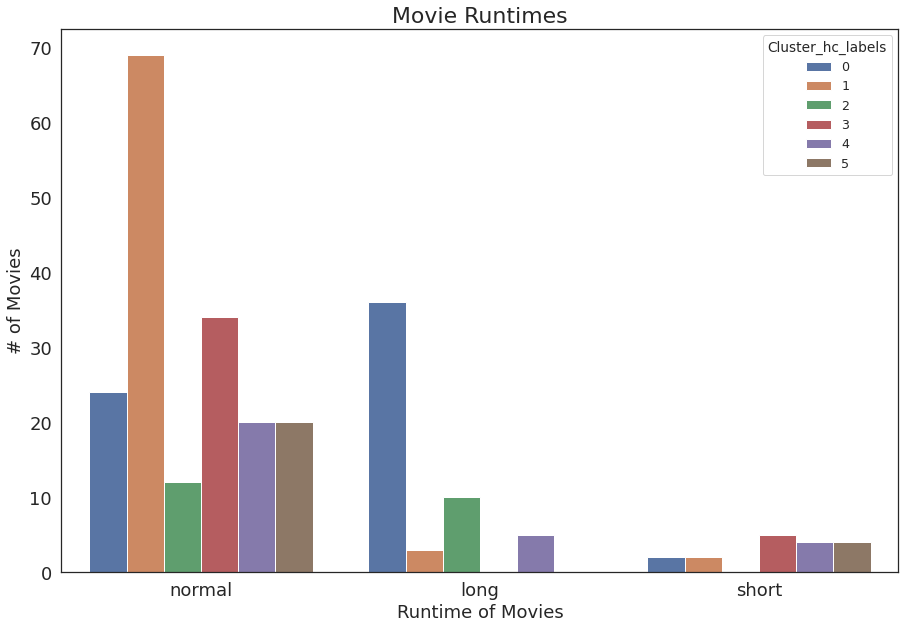

In [ ]:
# Runtime
plt.figure(figsize=(15,10))
sns.countplot(imdb['Runtime_bin'],hue=imdb['Cluster_hc_labels'])
plt.title('Movie Runtimes', fontsize=22)
plt.xlabel('Runtime of Movies', fontsize=18)
plt.ylabel('# of Movies', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
# Genre
# Since top 250 movies are mostly Drama, so it is a generic genre for most of the movies.
genre_df[imdb['Cluster_hc_labels'] == 0].sum(axis=0).sort_values(ascending=False).head() 


Drama        61
Biography    27
Crime        16
History      12
Adventure     8
dtype: int64

In [ ]:
genre_df[imdb['Cluster_hc_labels'] == 1].sum(axis=0).sort_values(ascending=False).head() 


Drama       50
Crime       17
Action      15
Thriller    15
Mystery     14
dtype: int64

In [ ]:
genre_df[imdb['Cluster_hc_labels'] == 2].sum(axis=0).sort_values(ascending=False).head()


Action       20
Adventure    18
Drama        11
Fantasy       6
Crime         4
dtype: int64

In [ ]:
genre_df[imdb['Cluster_hc_labels'] == 3].sum(axis=0).sort_values(ascending=False).head()


Drama      26
Comedy     17
Romance    10
Crime       9
Mystery     8
dtype: int64

In [ ]:
genre_df[imdb['Cluster_hc_labels'] == 4].sum(axis=0).sort_values(ascending=False).head()


Drama       29
Crime        6
Mystery      5
Thriller     5
Action       4
dtype: int64

In [ ]:
genre_df[imdb['Cluster_hc_labels'] == 5].sum(axis=0).sort_values(ascending=False).head()

Adventure    21
Animation    20
Comedy       14
Family        6
Action        4
dtype: int64

In [ ]:
# Director
dir_df[imdb['Cluster_hc_labels'] == 0].sum(axis=0).sort_values(ascending=False)

Martin Scorsese      6
Quentin Tarantino    3
Steven Spielberg     3
Stanley Kubrick      2
Akira Kurosawa       1
Christopher Nolan    1
Sergio Leone         1
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Hayao Miyazaki       0
Lee Unkrich          0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_hc_labels'] == 1].sum(axis=0).sort_values(ascending=False)

Stanley Kubrick      4
Sergio Leone         3
Quentin Tarantino    2
Alfred Hitchcock     1
Christopher Nolan    1
Martin Scorsese      1
Akira Kurosawa       0
Billy Wilder         0
Charles Chaplin      0
Hayao Miyazaki       0
Lee Unkrich          0
Steven Spielberg     0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_hc_labels'] == 2].sum(axis=0).sort_values(ascending=False)

Christopher Nolan    5
Steven Spielberg     3
Akira Kurosawa       0
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Hayao Miyazaki       0
Lee Unkrich          0
Martin Scorsese      0
Quentin Tarantino    0
Sergio Leone         0
Stanley Kubrick      0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_hc_labels'] == 3].sum(axis=0).sort_values(ascending=False)

Alfred Hitchcock     5
Billy Wilder         5
Charles Chaplin      5
Steven Spielberg     1
Akira Kurosawa       0
Christopher Nolan    0
Hayao Miyazaki       0
Lee Unkrich          0
Martin Scorsese      0
Quentin Tarantino    0
Sergio Leone         0
Stanley Kubrick      0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_hc_labels'] == 4].sum(axis=0).sort_values(ascending=False)

Akira Kurosawa       6
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Christopher Nolan    0
Hayao Miyazaki       0
Lee Unkrich          0
Martin Scorsese      0
Quentin Tarantino    0
Sergio Leone         0
Stanley Kubrick      0
Steven Spielberg     0
dtype: int64

In [ ]:
dir_df[imdb['Cluster_hc_labels'] == 5].sum(axis=0).sort_values(ascending=False)

Hayao Miyazaki       4
Lee Unkrich          4
Stanley Kubrick      1
Akira Kurosawa       0
Alfred Hitchcock     0
Billy Wilder         0
Charles Chaplin      0
Christopher Nolan    0
Martin Scorsese      0
Quentin Tarantino    0
Sergio Leone         0
Steven Spielberg     0
dtype: int64

In [ ]:
# Actors
actors_df[imdb['Cluster_hc_labels'] == 0].sum(axis=0).sort_values(ascending=False)

Robert De Niro       7
Al Pacino            4
Tom Hanks            4
Leonardo DiCaprio    4
Matt Damon           3
Christian Bale       2
Morgan Freeman       1
Clint Eastwood       1
Jack Nicholson       1
Brad Pitt            1
Mark Ruffalo         1
Tatsuya Nakadai      0
Kevin Spacey         0
James Stewart        0
Harrison Ford        0
Charles Chaplin      0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_hc_labels'] == 1].sum(axis=0).sort_values(ascending=False)

Kevin Spacey         4
Clint Eastwood       4
Morgan Freeman       3
Jack Nicholson       3
Brad Pitt            3
Robert De Niro       2
Harrison Ford        1
Leonardo DiCaprio    1
Mark Ruffalo         1
Matt Damon           1
Tom Hanks            0
Tatsuya Nakadai      0
Al Pacino            0
James Stewart        0
Christian Bale       0
Charles Chaplin      0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_hc_labels'] == 2].sum(axis=0).sort_values(ascending=False)

Harrison Ford        5
Christian Bale       3
Mark Ruffalo         2
Leonardo DiCaprio    1
Al Pacino            0
Tom Hanks            0
Tatsuya Nakadai      0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Kevin Spacey         0
Brad Pitt            0
James Stewart        0
Jack Nicholson       0
Clint Eastwood       0
Charles Chaplin      0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_hc_labels'] == 3].sum(axis=0).sort_values(ascending=False)

Charles Chaplin      5
James Stewart        4
Al Pacino            0
Mark Ruffalo         0
Tom Hanks            0
Tatsuya Nakadai      0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Kevin Spacey         0
Leonardo DiCaprio    0
Brad Pitt            0
Jack Nicholson       0
Harrison Ford        0
Clint Eastwood       0
Christian Bale       0
Toshirô Mifune       0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_hc_labels'] == 4].sum(axis=0).sort_values(ascending=False)

Toshirô Mifune       4
Tatsuya Nakadai      4
Leonardo DiCaprio    0
Tom Hanks            0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Mark Ruffalo         0
Al Pacino            0
Brad Pitt            0
James Stewart        0
Jack Nicholson       0
Harrison Ford        0
Clint Eastwood       0
Christian Bale       0
Charles Chaplin      0
Kevin Spacey         0
dtype: int64

In [ ]:
actors_df[imdb['Cluster_hc_labels'] == 5].sum(axis=0).sort_values(ascending=False)

Tom Hanks            2
Al Pacino            0
Leonardo DiCaprio    0
Tatsuya Nakadai      0
Robert De Niro       0
Morgan Freeman       0
Matt Damon           0
Mark Ruffalo         0
Kevin Spacey         0
Brad Pitt            0
James Stewart        0
Jack Nicholson       0
Harrison Ford        0
Clint Eastwood       0
Christian Bale       0
Charles Chaplin      0
Toshirô Mifune       0
dtype: int64

In [ ]:
country_df[imdb['Cluster_hc_labels'] == 0].sum(axis=0).sort_values(ascending=False)

United States     52
United Kingdom    12
France             6
Italy              4
Germany            3
India              3
Australia          1
Canada             1
Japan              1
Spain              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_hc_labels'] == 1].sum(axis=0).sort_values(ascending=False)

United States     56
United Kingdom    22
France             9
Germany            8
Spain              6
Canada             3
Italy              3
Australia          2
India              1
Japan              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_hc_labels'] == 2].sum(axis=0).sort_values(ascending=False)

United States     22
United Kingdom     7
Canada             2
Australia          0
France             0
Germany            0
India              0
Italy              0
Japan              0
Spain              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_hc_labels'] == 3].sum(axis=0).sort_values(ascending=False)

United States     37
Germany            1
United Kingdom     1
Australia          0
Canada             0
France             0
India              0
Italy              0
Japan              0
Spain              0
dtype: int64

In [ ]:
country_df[imdb['Cluster_hc_labels'] == 4].sum(axis=0).sort_values(ascending=False)

Japan             10
France             5
Italy              4
India              3
Australia          2
Germany            1
United States      1
Canada             0
Spain              0
United Kingdom     0
dtype: int64

In [ ]:
country_df[imdb['Cluster_hc_labels'] == 5].sum(axis=0).sort_values(ascending=False)

United States     18
Japan              4
United Kingdom     3
Australia          1
Spain              1
Canada             0
France             0
Germany            0
India              0
Italy              0
dtype: int64

In [ ]:
# Plot Words
plot_df[imdb['Cluster_hc_labels'] == 0].sum(axis=0).sort_values(ascending=False).head()

war         1.182798
american    1.142951
life        1.108514
world       0.689430
man         0.668472
dtype: float64

In [ ]:
plot_df[imdb['Cluster_hc_labels'] == 1].sum(axis=0).sort_values(ascending=False).head()

find     1.281129
year     1.158327
young    0.990578
man      0.930266
help     0.918168
dtype: float64

In [ ]:
plot_df[imdb['Cluster_hc_labels'] == 2].sum(axis=0).sort_values(ascending=False).head()

help      0.391666
force     0.368883
city      0.321508
family    0.301767
world     0.244134
dtype: float64

In [ ]:
plot_df[imdb['Cluster_hc_labels'] == 3].sum(axis=0).sort_values(ascending=False).head()

murder    0.574135
woman     0.548673
new       0.541141
help      0.508242
try       0.481866
dtype: float64

In [ ]:
plot_df[imdb['Cluster_hc_labels'] == 4].sum(axis=0).sort_values(ascending=False).head()

find     0.809635
life     0.709269
son      0.597150
young    0.534538
work     0.516104
dtype: float64

In [ ]:
plot_df[imdb['Cluster_hc_labels'] == 5].sum(axis=0).sort_values(ascending=False).head()

young     0.770339
old       0.433175
new       0.343962
family    0.310285
child     0.306019
dtype: float64

In [ ]:
imdb.to_excel('Clustered.xlsx')

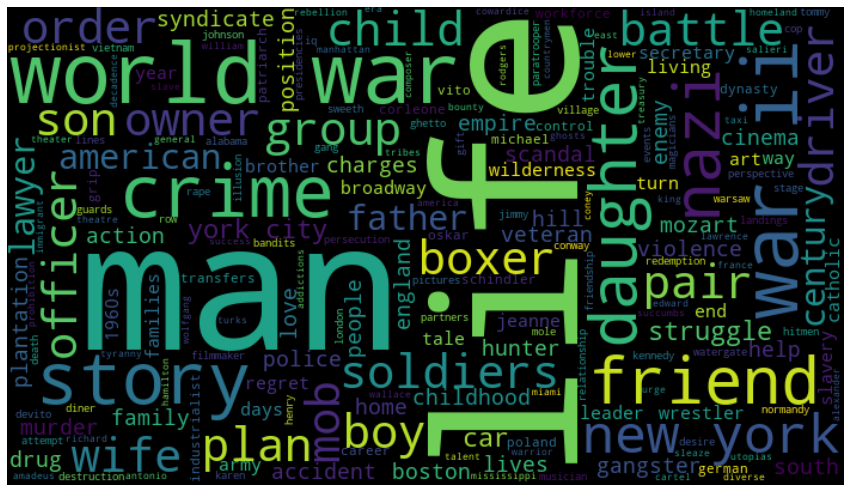

In [ ]:
from wordcloud import WordCloud
# Word Cloud Plot
def preprocess(plot):
    vocab = nlp(plot)
    tokens=[]
    # tokens = [token for token in re.split('\W+',plot)]
    for token in vocab:
        if 'noun' in spacy.explain(token.tag_):
          tokens.append(token.lower_)

    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in string.punctuation:
            cleaned_tokens.append(token)
    return cleaned_tokens
# Cluster 0
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==0]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

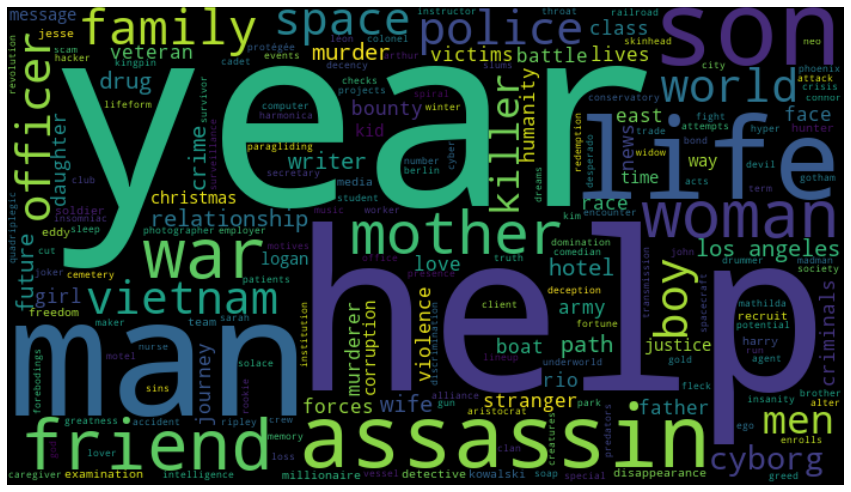

In [ ]:
# Cluster 1
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==1]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

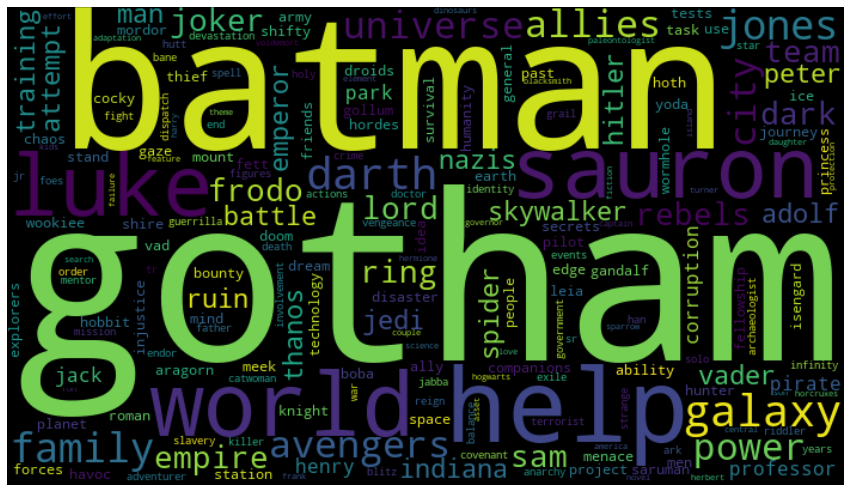

In [ ]:
# Cluster 2
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==2]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

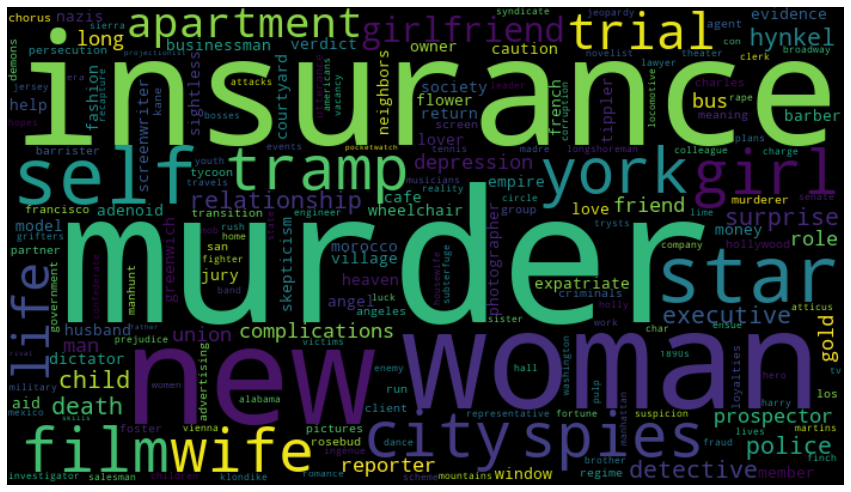

In [ ]:
# Cluster 3
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==3]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

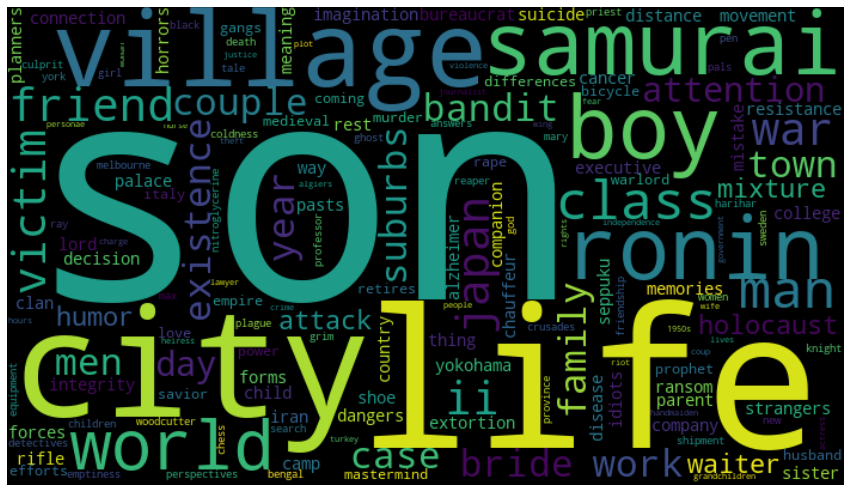

In [ ]:
# Cluster 4
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==4]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

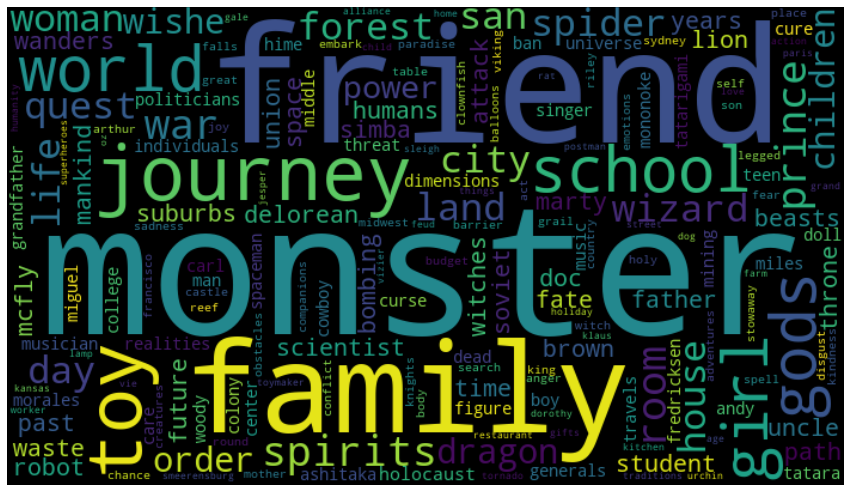

In [ ]:
# Cluster 5
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==5]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

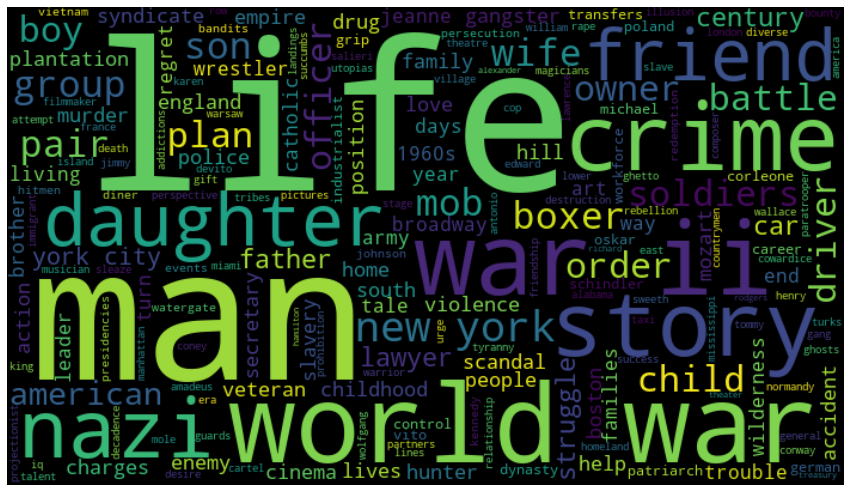

In [ ]:
# Cluster 0
cluster1_plot = []
for plot in imdb[imdb['Cluster_hc_labels']==0]['Plot']:
  cluster1_plot.extend(preprocess(plot))

plt.figure(figsize=(15,10))
wc = WordCloud(width=700, height=400).generate(' '.join(cluster1_plot))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

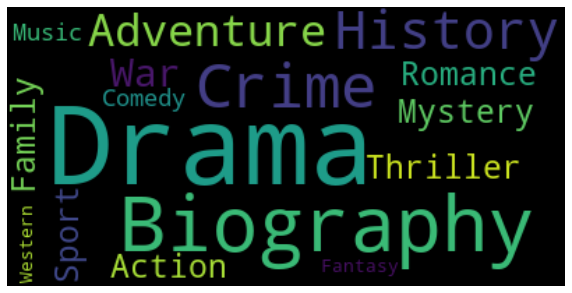

In [ ]:
genre_c1 = []
for genre in imdb[imdb['Cluster_hc_labels']==0]['Genre']:
  genre_c1.extend(genre.split(','))

# plt.figure(figsize=(15,10))
wc = WordCloud().generate(' '.join(genre_c1))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

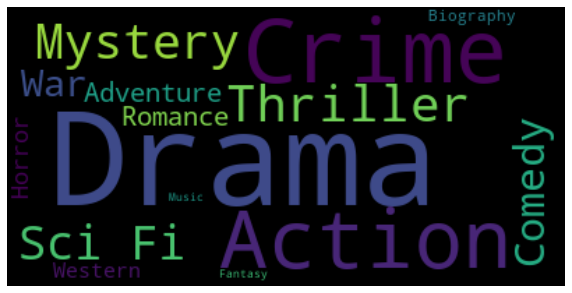

In [ ]:
genre_c1 = []
for genre in imdb[imdb['Cluster_hc_labels']==1]['Genre']:
  genre_c1.extend(genre.split(','))

# plt.figure(figsize=(15,10))
wc = WordCloud().generate(' '.join(genre_c1))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

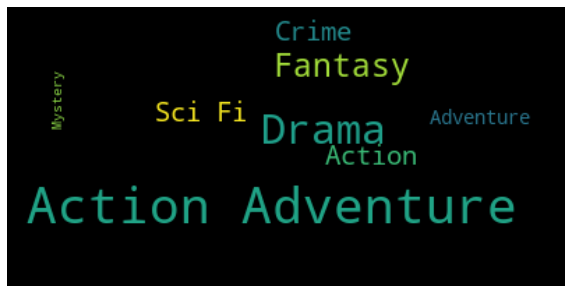

In [ ]:
genre_c1 = []
for genre in imdb[imdb['Cluster_hc_labels']==2]['Genre']:
  genre_c1.extend(genre.split(','))

# plt.figure(figsize=(15,10))
wc = WordCloud().generate(' '.join(genre_c1))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

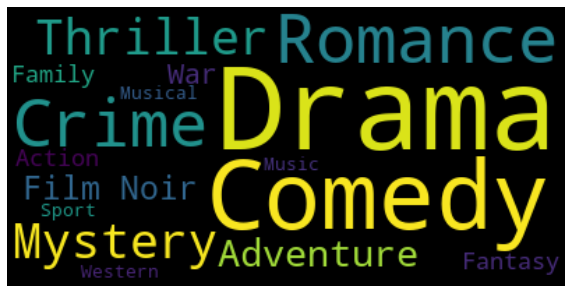

In [ ]:
genre_c1 = []
for genre in imdb[imdb['Cluster_hc_labels']==3]['Genre']:
  genre_c1.extend(genre.split(','))

# plt.figure(figsize=(15,10))
wc = WordCloud().generate(' '.join(genre_c1))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

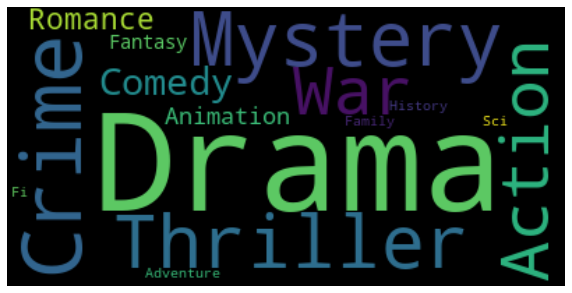

In [ ]:
genre_c1 = []
for genre in imdb[imdb['Cluster_hc_labels']==4]['Genre']:
  genre_c1.extend(genre.split(','))

# plt.figure(figsize=(15,10))
wc = WordCloud().generate(' '.join(genre_c1))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

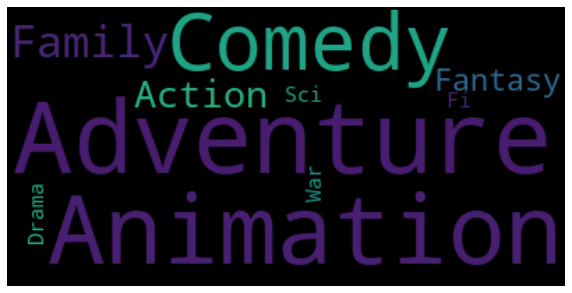

In [ ]:
genre_c1 = []
for genre in imdb[imdb['Cluster_hc_labels']==5]['Genre']:
  genre_c1.extend(genre.split(','))

# plt.figure(figsize=(15,10))
wc = WordCloud().generate(' '.join(genre_c1))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

### Cluester Comparison

In [ ]:
pd.crosstab(imdb['Cluster_Labels'],imdb['Cluster_hc_labels'], margins = True)

Cluster_hc_labels   0   1   2   3   4   5  All
Cluster_Labels                                
0                  30  69   0   0   1   0  100
1                  12   2   4  39   0   3   60
2                   0   0   0   0   0  21   21
3                  14   1  18   0   2   0   35
4                   6   2   0   0  26   0   34
All                62  74  22  39  29  24  250

# The END